# Исследование данных о продаже компьютерных игр интернет-магазина "Стримчик"

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Данные приведены до 2016 года. Данные нужны для прогноза продажи на 2017 год по данным 2016-го. В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

**Описание данных**
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
- Данные за 2016 год могут быть неполными.

Для прогноза продаж на 2017 год необходимо выполнить следующие задачи:

1. проверить и преобразовать исходные данные провести поиск аномалий, сделать соответствие с реальными данными
2. выбрать актуальный период, на основе которого будем делать выводы
3. определить прибыльные и популярные платформы
4. выявить прибыльные и популярные жанры
5. определить влияние разных факторов таких как оценка, рейтинг или регион на продажи
6. сделасть выводы и определить наиболее возможные прибыльные платформы в 2017 году

### Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
#Импортируем необходимые для анализа библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Откроем файл games.csv
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('games.csv')

### Шаг 2. Проведем подготовку данных

In [3]:
#Выведем первые строки датафрейма games.csv
display(data.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
#Рассмотрм основную информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Замена названия столбцов

In [5]:
#Приведем данные к змеинному регистру
data = data.rename(columns={'Name' : 'name',
                           'Platform' : 'platform',
                           'Year_of_Release' : 'year_of_realease',
                           'Genre' : 'genre',
                           'NA_sales' : 'na_sales',
                           'EU_sales' : 'eu_sales',
                           'JP_sales' : 'jp_sales',
                           'Other_sales' : 'other_sales',
                           'Critic_Score' : 'critic_score',
                           'User_Score' : 'user_score',
                           'Rating' : 'rating'})

In [6]:
#Проверим изменения
data.columns

Index(['name', 'platform', 'year_of_realease', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### Обработка пропусков

In [7]:
#Проверим наличие пустых ячеек
data.isna().sum()

name                   2
platform               0
year_of_realease     269
genre                  2
na_sales               0
eu_sales               0
jp_sales               0
other_sales            0
critic_score        8578
user_score          6701
rating              6766
dtype: int64

In [8]:
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = False, fontsize = 16)
            .set_title('Диаграмма пустых значений' + "\n", fontsize = 22, color = 'SteelBlue')  
        );    
        plt.title('Пропущенные значения, %' + "\n", fontsize=22, color='SteelBlue')
        plt.xlabel('Процент пропусков', fontsize=22)
        plt.ylabel('Столбцы с пропусками', fontsize=22)
        plt.xlim(0, 100) 
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

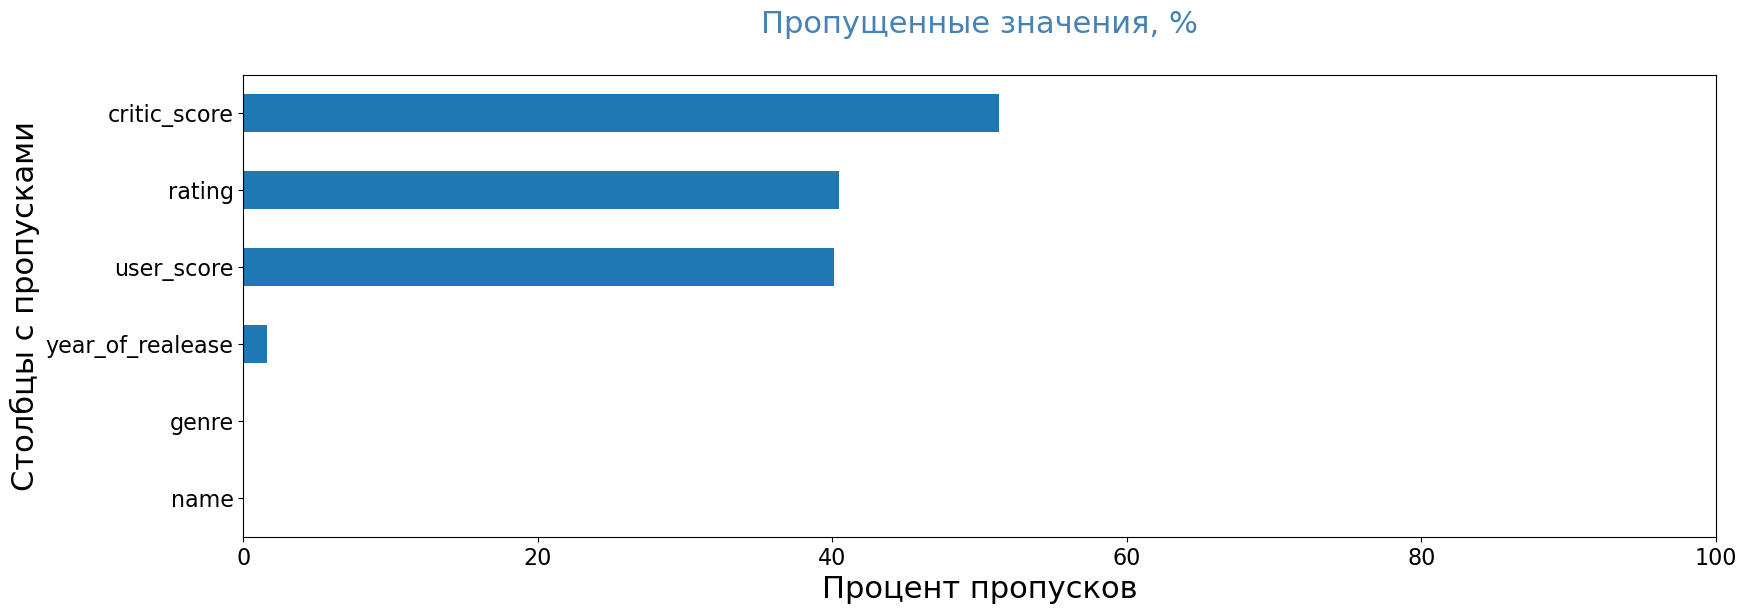

In [9]:
pass_value_barh(data)

Рассмотрим каждый столбец с пропусками:

- name имеет 2 пропуска, данные две строки рассмотрены ниже, они не имеют значимой информации поэтому следует их исключить из выборки 

Причиной пропусков значений мог быть сбой, либо неправильно внесенные данные.
- year_of_realease имеет 269 пропусков, в дальнейшем анализе будет использоваться информация по годам, так как большая часть пропусков представлена по играм, у которых год релиза указан на других платформах, можем заменить пропуски этим значением (проверка указана ниже).

Причиной данных пропусков может быть человеческий фактор или же сбой в программе.
- genre имеет 2 пропуска и не может быть заменено логически, также эти пропуски соответствуют данным с пропусками в имени.

Причиной пропусков значений мог быть сбой, либо неправильно внесенные данные.
- critic_score 8578 пропусков, мы не можем заменять или удалять пустые значения, так как это может исказить данные, ведь на некоторх платформах может не быть оценки, по этой же причине мы не будем заменять пропуски в графах.

Причиной пропусков значений может быть отсутствие анализа данной игры критиками на данной платформе.
- user_score 6701 пропусков - удаление или замена пропусков может исказить данные.

Причиной пропусков значений может быть отсутствие анализа данной игры пользователями на данной платформе.
- rating 6766 пропусков - удаление или замена пропусков может исказить данные.

Причиной пропусков значений может быть в связи с неопределенностью к какому рейтингу отнести данный продукт.

In [10]:
#Проверка значимости информации по строкам с пустой графой name (см.объяснение пропусков значений)
data[data['name'].isna()]

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [11]:
#Проверка данных по годам (см.объяснение пропусков значений)
data[data['name'] == 'LEGO Batman: The Videogame']

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
397,LEGO Batman: The Videogame,X360,2008.0,Action,2.04,1.02,0.0,0.32,76.0,7.9,E10+
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.0,0.29,74.0,7.9,E10+
460,LEGO Batman: The Videogame,DS,2008.0,Action,1.75,1.01,0.0,0.29,72.0,8,E10+
1519,LEGO Batman: The Videogame,PS3,2008.0,Action,0.72,0.39,0.0,0.19,75.0,7.7,E10+
1538,LEGO Batman: The Videogame,PSP,NaN,Action,0.57,0.44,0.0,0.27,73.0,7.4,E10+
1553,LEGO Batman: The Videogame,PS2,2008.0,Action,0.72,0.03,0.0,0.52,77.0,8.9,E10+
12465,LEGO Batman: The Videogame,PC,2008.0,Action,0.02,0.03,0.0,0.01,80.0,7.8,E10+


In [12]:
#Исключим незаменяемые данные из выборки
data = data.dropna(subset=['name'])

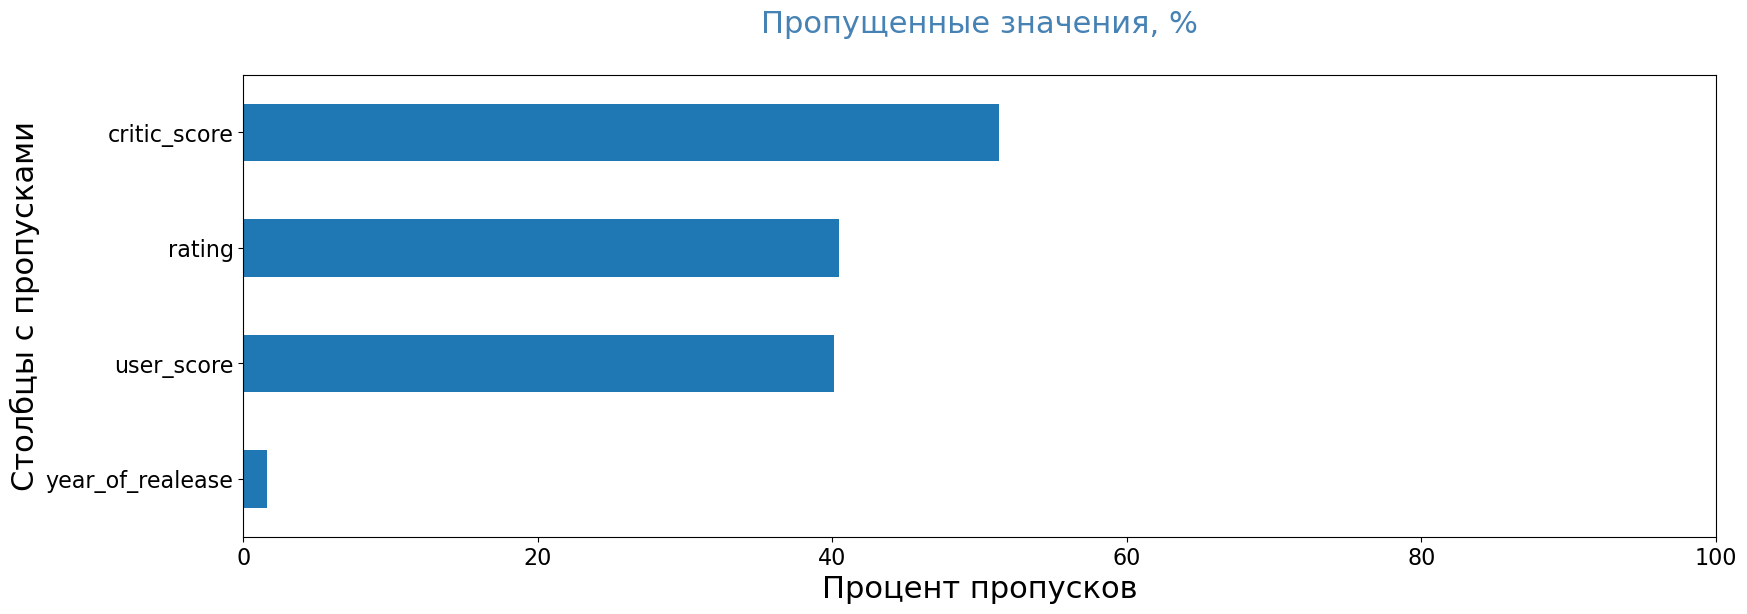

In [13]:
pass_value_barh(data)

In [14]:
#Проверим количество пустых значений по каждой платформе
plut_null = data[data['year_of_realease'].isna()].pivot_table(index='platform', values='name', aggfunc='count')

display(plut_null)

,name
platform,
2600,17
3DS,8
DS,30
GB,1
GBA,11
GC,14
N64,3
PC,17
PS,7


In [15]:
#Проверим, все ли данные могут замениться подобным образом
data['name'].value_counts()

Need for Speed: Most Wanted                         12
Ratatouille                                          9
LEGO Marvel Super Heroes                             9
FIFA 14                                              9
Madden NFL 07                                        9
                                                    ..
Jewels of the Tropical Lost Island                   1
Sherlock Holmes and the Mystery of Osborne House     1
The King of Fighters '95 (CD)                        1
Megamind: Mega Team Unite                            1
Haitaka no Psychedelica                              1
Name: name, Length: 11559, dtype: int64

Проверим данные на наличие неточностей.
Имеется отклонение начального значения для платформы DS, которая была основана в 2004 году.

Проверим и устраним аномалию.

In [16]:
# жизненный срок платформы

years_of_life = data.pivot_table(index='platform',values='year_of_realease',aggfunc=['min','max'])
years_of_life.columns=['min','max']
years_of_life['years_of_life']=years_of_life['max']-years_of_life['min']
years_of_life

# years_of_life.sort_values(by = 'years_of_life', ascending = False)

,min,max,years_of_life
platform,,,
2600,1980.0,1989.0,9.0
3DO,1994.0,1995.0,1.0
3DS,2011.0,2016.0,5.0
DC,1998.0,2008.0,10.0
DS,1985.0,2013.0,28.0
GB,1988.0,2001.0,13.0
GBA,2000.0,2007.0,7.0
GC,2001.0,2007.0,6.0
GEN,1990.0,1994.0,4.0


In [17]:
#Рассмотрим строки которые не входят в указанный промежуток
data[(data['platform'] == 'DS')&(data['year_of_realease'] < 2004)]

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15957,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN


In [18]:
data = data[~((data['platform'] == 'DS')&(data['year_of_realease'] < 2004))]
data = data.reset_index(drop=True)

Дата является ключевым столбцом, данные по которому мы не можем высчитать. Также имеются игры с одним наименованием, у которых дата релиза на разных платформах отличается. Но чтобы не потерять данные по этим строкам, для строк где это возможно можем прописать медианное значение.

Для игр представленных на одной платформе мы не сможем заменить значения, поэтому придется их удалить.

In [19]:
#Составим сводную таблицу с данными по годам по каждой игре
year = data.pivot_table(index=['name'], values='year_of_realease', aggfunc='median')
year = year.reset_index()
year = year.rename(columns={'year_of_realease' : 'median_year'})

In [20]:
#Создадим промежуточную таблицу для вычислений
year_platform = data
year_platform = year_platform.drop(columns=(['genre', 'na_sales', 'eu_sales', 
                                             'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']))

In [21]:
plut_life = data.pivot_table(index='platform',values='year_of_realease',aggfunc=['min','max'])
plut_life.columns=['min','max']
plut_life['years_of_life'] = plut_life['max'] - plut_life['min']
plut_life = plut_life.reset_index()

In [22]:
#Дополним данными промежуточную таблицу для вычислений
year_platform = year_platform.merge(plut_life, on='platform', how='left')
year_platform = year_platform.merge(year, on='name', how='left')
year_platform['median_platform_year'] = round(year_platform['min'] + ((year_platform['max'] - year_platform['min']) / 2))

In [23]:
#Заполним значения 'year_of_realease' в промежуточной таблице
for i in year_platform.index:
    if year_platform.loc[i, 'min'] <= year_platform.loc[i, 'median_year'] <= year_platform.loc[i, 'max']:
        year_platform.loc[i, 'year_of_realease'] = year_platform.loc[i, 'median_year']
    else:
        year_platform.loc[i, 'year_of_realease'] = year_platform.loc[i, 'median_platform_year']

In [24]:
# жизненный срок платформы

years_of_life = data.pivot_table(index='platform',values='year_of_realease',aggfunc=['min','max'])
years_of_life.columns=['min','max']
years_of_life['years_of_life']=years_of_life['max']-years_of_life['min']
years_of_life

# years_of_life.sort_values(by = 'years_of_life', ascending = False)

,min,max,years_of_life
platform,,,
2600,1980.0,1989.0,9.0
3DO,1994.0,1995.0,1.0
3DS,2011.0,2016.0,5.0
DC,1998.0,2008.0,10.0
DS,2004.0,2013.0,9.0
GB,1988.0,2001.0,13.0
GBA,2000.0,2007.0,7.0
GC,2001.0,2007.0,6.0
GEN,1990.0,1994.0,4.0


In [25]:
#Заполним пустые значения в таблице data['year_of_realease']
data = data.merge(year_platform, on=(['name', 'platform']), how='left')
data['year_of_realease_x'] = data['year_of_realease_x'].fillna(data['year_of_realease_y'])
data = data.drop(columns=(['year_of_realease_y', 'min', 'max', 'years_of_life', 'median_year', 'median_platform_year']))
data = data.rename(columns={'year_of_realease_x' : 'year_of_realease'})

In [26]:
# жизненный срок платформы

years_of_life = data.pivot_table(index='platform',values='year_of_realease',aggfunc=['min','max'])
years_of_life.columns=['min','max']
years_of_life['years_of_life']=years_of_life['max']-years_of_life['min']
years_of_life

# years_of_life.sort_values(by = 'years_of_life', ascending = False)

,min,max,years_of_life
platform,,,
2600,1980.0,1989.0,9.0
3DO,1994.0,1995.0,1.0
3DS,2011.0,2016.0,5.0
DC,1998.0,2008.0,10.0
DS,2004.0,2013.0,9.0
GB,1988.0,2001.0,13.0
GBA,2000.0,2007.0,7.0
GC,2001.0,2007.0,6.0
GEN,1990.0,1994.0,4.0


In [27]:
#проверим пропуски по графе
data['year_of_realease'].isna().sum()

0

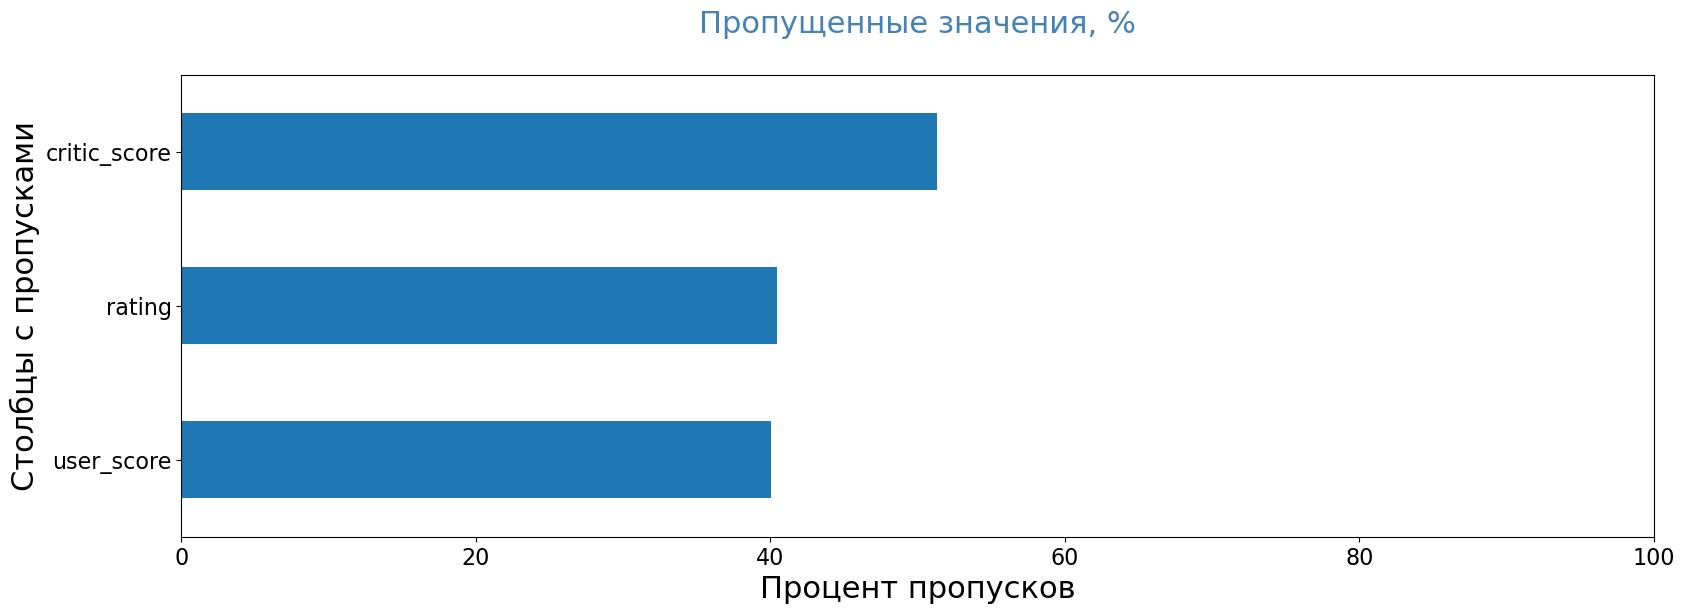

In [28]:
pass_value_barh(data)

In [29]:
#Проверим датафрейм на дубли
data.duplicated().sum()

8

In [30]:
#После преобразований в таблице появились дули
data[data.duplicated()]

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
605,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
1191,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1593,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1748,Sonic the Hedgehog,PS3,2006.0,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
4131,Sonic the Hedgehog,PS3,2006.0,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+
5977,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
11721,Need for Speed: Most Wanted,PC,2012.0,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T
16235,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


In [31]:
#Удалим явные дубликаты
data = data.drop_duplicates()

In [32]:
#Проверим дубликаты, приведя ключевые столбцы к нижнему регистру
data['name'] = data['name'].str.lower()
data['platform'] = data['platform'].str.lower()

In [33]:
data.duplicated().sum()

0

In [34]:
#Проверим дубликаты по трем ключевым столбцам
data[data.duplicated(subset=['name', 'platform', 'year_of_realease'])]

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
4130,sonic the hedgehog,ps3,2006.0,Platform,0.0,0.48,0.0,0.0,43.0,4.1,E10+
16234,madden nfl 13,ps3,2012.0,Sports,0.0,0.01,0.0,0.0,83.0,5.5,E


In [35]:
#Так как некоторую часть дат заполняли мы, возможны дубликаты при проверке по имени и платформе 
data[data.duplicated(subset=['name', 'platform'])]

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1592,need for speed: most wanted,x360,2005.0,Racing,1.0,0.13,0.02,0.10,83.0,8.5,T
4130,sonic the hedgehog,ps3,2006.0,Platform,0.0,0.48,0.00,0.00,43.0,4.1,E10+
11720,need for speed: most wanted,pc,2012.0,Racing,0.0,0.06,0.00,0.02,82.0,8.5,T
16234,madden nfl 13,ps3,2012.0,Sports,0.0,0.01,0.00,0.00,83.0,5.5,E


In [36]:
#У игр указаны разные года, исключать из выборки из не будем
data[data['name'] == 'madden nfl 13']

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,madden nfl 13,x360,2012.0,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
604,madden nfl 13,ps3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
3989,madden nfl 13,wii,2012.0,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
5891,madden nfl 13,psv,2012.0,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
7071,madden nfl 13,wiiu,2012.0,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
16234,madden nfl 13,ps3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


In [37]:
#Перезапишем индексы в таблице
data = data.reset_index(drop=True)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16712 entries, 0 to 16711
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              16712 non-null  object 
 1   platform          16712 non-null  object 
 2   year_of_realease  16712 non-null  float64
 3   genre             16712 non-null  object 
 4   na_sales          16712 non-null  float64
 5   eu_sales          16712 non-null  float64
 6   jp_sales          16712 non-null  float64
 7   other_sales       16712 non-null  float64
 8   critic_score      8137 non-null   float64
 9   user_score        10014 non-null  object 
 10  rating            9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [39]:
#Рассмотрим данные по графе rating
data['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

Расшифровки:

- «E» («Everyone») — «Для всех»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «EC» («Early childhood») — «Для детей младшего возраста»: слишком малое значение можно объединить с «E10+»
- "K-A" ("Kids to Adults"): можно объединить с «T» («Teen»)
- «RP» («Rating Pending») — «Рейтинг ожидается»
- «AO» («Adults Only 18+») — «Только для взрослых»: слишком мало значений можно объединить с категорией «M»

In [40]:
#Количество строк с пустым рейтингом
data[data['rating'].isna()].shape

(6763, 11)

In [41]:
#Количество строк с пустым рейтингом и незаполненными оценками критиков и пользователй
data[(data['rating'].isna())&(data['critic_score'].isna())&(data['user_score'].isna())].shape

(6618, 11)

In [42]:
#Рассмотрим строку с наименьшим количеством по рейтингу
data[(data['rating'] == 'AO')]

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
874,grand theft auto: san andreas,xb,2005.0,Action,1.26,0.61,0.0,0.09,93.0,8.6,AO


In [43]:
#На других платформах данная игра приравнена к категории М
data[(data['name'] == 'grand theft auto: san andreas')]

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
17,grand theft auto: san andreas,ps2,2004.0,Action,9.43,0.40,0.41,10.57,95.0,9,M
874,grand theft auto: san andreas,xb,2005.0,Action,1.26,0.61,0.00,0.09,93.0,8.6,AO
2114,grand theft auto: san andreas,pc,2005.0,Action,0.00,0.93,0.00,0.04,93.0,8.9,M
10310,grand theft auto: san andreas,x360,2008.0,Action,0.08,0.02,0.00,0.01,NaN,7.5,M


In [44]:
#Рассмотрим строки с неопределенным рейтингом
data[(data['rating'] == 'RP')]

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13671,clockwork empires,pc,2000.0,Strategy,0.0,0.04,0.0,0.00,58.0,3.8,RP
14268,supreme ruler: cold war,pc,2011.0,Strategy,0.0,0.03,0.0,0.01,63.0,6.8,RP
16177,wrc: fia world rally championship,pc,2005.0,Racing,0.0,0.01,0.0,0.00,65.0,NaN,RP


In [45]:
#Также как и в предыдущем примере рейтинги отличаются
data[(data['name'] == 'wrc: fia world rally championship')]

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
7583,wrc: fia world rally championship,ps3,2011.0,Racing,0.00,0.14,0.01,0.04,68.0,4.5,NaN
9826,wrc: fia world rally championship,x360,2005.0,Racing,0.00,0.10,0.00,0.02,66.0,6,E10+
14232,wrc: fia world rally championship,psp,2005.0,Racing,0.02,0.01,0.00,0.00,67.0,7.8,E
16177,wrc: fia world rally championship,pc,2005.0,Racing,0.00,0.01,0.00,0.00,65.0,NaN,RP


Рассмотрев несколько примеров, можно прийти к выводу, что большую роль в определении рейтинга решает платформа. Одна и та же игра может получить разный рейтинг, поэтому пустые значения мы не можем заполнить значением, которое чаще всего встречается. Большинство игр не имеющих рейтинга, также не имеет его и на других платформах.

Стоит отметить, что из  6763 пропусков 6618 объединяет отсутствие показателей в графах critic_score и user_score.

В данном случае более рациональным будет определить рейтинг как «RP» («Rating Pending») — «Рейтинг ожидается», также следует категоризировать данные для устранения рейтингов с небольшими значениями.

In [46]:
#Заполним пропуски
data['rating'] = data['rating'].fillna('RP')

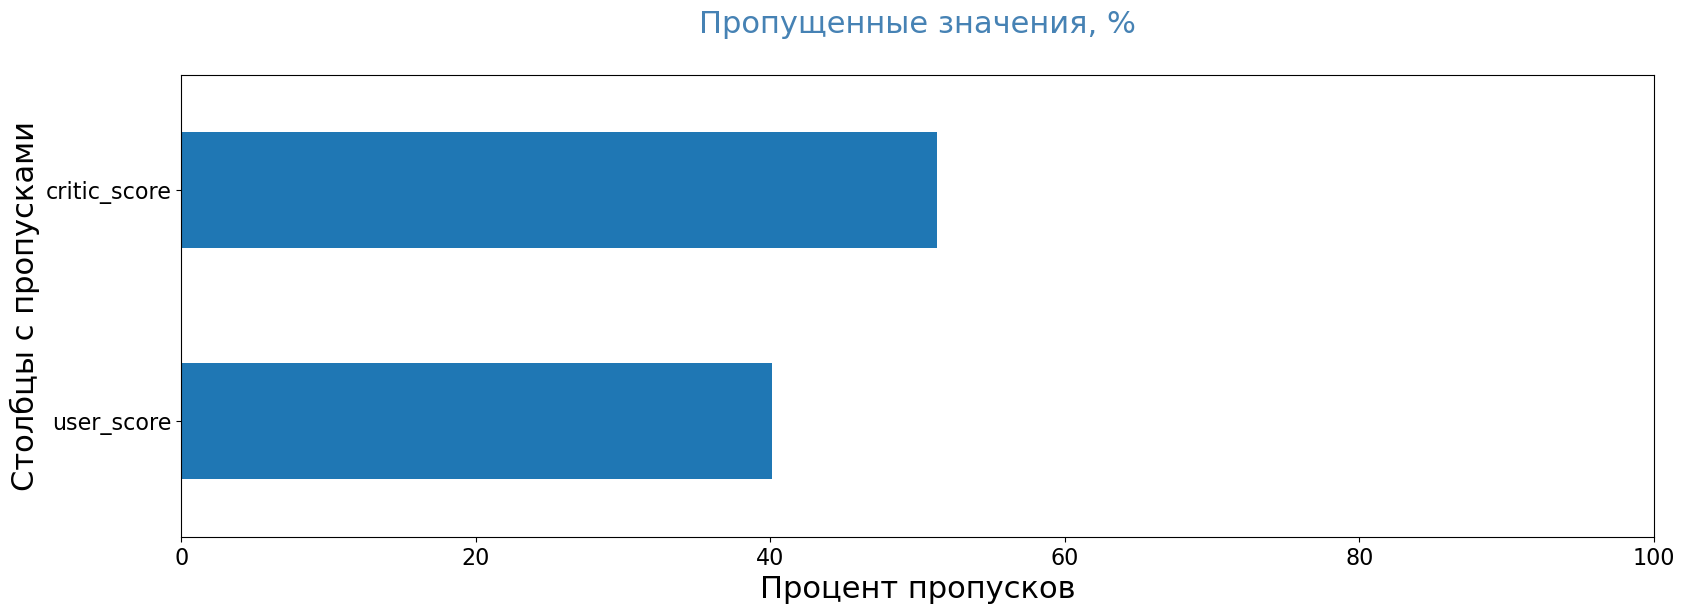

In [47]:
pass_value_barh(data)

In [48]:
data['rating'].value_counts()

RP      6766
E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
AO         1
Name: rating, dtype: int64

In [49]:
#Категоризируем данные по рейтингу
def categorize_rating(row):
    try:
        if row in ('E'):
            return 'E'
        elif row in ('T', 'K-A'):
            return 'T'
        elif row in ('M', 'AO'):
            return 'M'
        elif row in ('E10+', 'EC'):
            return 'E10+'
        elif row in ('RP'):
            return 'RP'
    except:
        pass

In [50]:
#Применим функцию к таблице и запишем категории для каждой строки
data['categorize_rating'] = data['rating'].apply(categorize_rating)

In [51]:
data['categorize_rating'].value_counts()

RP      6766
E       3990
T       2964
M       1564
E10+    1428
Name: categorize_rating, dtype: int64

Игры могут быть с неопределенным рейтингом в разных случаях: если являются относительно новыми или если являются непопулярными, в этом случае определение рейтинга может затянуться на неопределенное время. Также стоит учитывать, что большая часть игр с неопределнным рейтингом не имеет оценок критиков и пользователей, что может быть также последствием непопулярности, новизны или отсутствия бюджета на раскрутку и доп ресурсы.

##### Аббревиатура 'tbd' в столбце с оценкой пользователей

'tbd' в столбце с оценкой пользователей - это акроним, служит для отметки неясностей или пропусков, которые надо заполнить, в информации требований.

In [52]:
#Заменим значение tbd на пустое
data['user_score'] = data['user_score'].replace('tbd', 'NaN')

#### Преобразуем данные в нужные типы. 

- Данные столбца year_of_realease нужно привести к целочисленному типу данных, так как год не может быть дробным числом.
- Значения в столбце user_score необходимо привести к вещественному типу данных, так как оценка пользователей это число (максимум 10).

In [53]:
#Преобразуем год к целочисленному формату
data['year_of_realease'] = data['year_of_realease'].astype('int')

In [54]:
#Преобразуем оценку пользователей к вещественному числу
data['user_score'] = data['user_score'].astype('float')

In [55]:
#Проверим все выше сделанные преобразования
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16712 entries, 0 to 16711
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               16712 non-null  object 
 1   platform           16712 non-null  object 
 2   year_of_realease   16712 non-null  int32  
 3   genre              16712 non-null  object 
 4   na_sales           16712 non-null  float64
 5   eu_sales           16712 non-null  float64
 6   jp_sales           16712 non-null  float64
 7   other_sales        16712 non-null  float64
 8   critic_score       8137 non-null   float64
 9   user_score         7590 non-null   float64
 10  rating             16712 non-null  object 
 11  categorize_rating  16712 non-null  object 
dtypes: float64(6), int32(1), object(5)
memory usage: 1.5+ MB



#### Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [56]:
#Посчитаем суммаерные продажи во всех регионах и запишем в столбец sales
#data['sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data['sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [57]:
#Рассмотрим получившуюся таблицу
data.head()

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,categorize_rating,sales
0,wii sports,wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,E,82.54
1,super mario bros.,nes,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,RP,RP,40.24
2,mario kart wii,wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,E,35.52
3,wii sports resort,wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,E,32.77
4,pokemon red/pokemon blue,gb,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,RP,RP,31.38


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16712 entries, 0 to 16711
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               16712 non-null  object 
 1   platform           16712 non-null  object 
 2   year_of_realease   16712 non-null  int32  
 3   genre              16712 non-null  object 
 4   na_sales           16712 non-null  float64
 5   eu_sales           16712 non-null  float64
 6   jp_sales           16712 non-null  float64
 7   other_sales        16712 non-null  float64
 8   critic_score       8137 non-null   float64
 9   user_score         7590 non-null   float64
 10  rating             16712 non-null  object 
 11  categorize_rating  16712 non-null  object 
 12  sales              16712 non-null  float64
dtypes: float64(7), int32(1), object(5)
memory usage: 1.6+ MB


Вывод по итогам раздела: 

Представленные в изначальном документе данные требовали обработки для дальнейшего исследования, такой как:
1. преобразование названия столбцов, наименования были приведены к нижнему регистру 
2. выявление аномалий - для платформы DS были заполнены некорректные значение в графе год релиза, в связи с чем следовало искажение информации о сроках деятельности платформы в целом 
3. заполнение пропусков - в ключевой графе год релиза были логически заполнены ячейки на основе общих данных, также заполнены пропуски в графе рейтинга ESRB и категоризированы для удобства рассмотрения при последуюущих действиях
4. удаление явных и неявных дубликатов - после преобразований в таблице были выявлены дубликаты, для этого данные были преобразованы к нижнему регистру, также дубликаты были найдены и устранены среди комбинаций ключевых столбцов.

### Шаг 3. Проведем исследовательский анализ данных

#### Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [59]:
#Сформируем сводную таблицу по играм и годам
games = (data
         .pivot_table(index=['name'], values='year_of_realease')
         .reset_index()
        )
games['year_of_realease'] = games['year_of_realease'].astype('int')
display(games.head())

,name,year_of_realease
0,beyblade burst,2016
1,fire emblem fates,2015
2,frozen: olaf's quest,2013
3,haikyu!! cross team match!,2016
4,tales of xillia 2,2012


In [60]:
#Вычислим количество игр выпущенных в промежутке 1980-2016
games.groupby('year_of_realease').count()

,name
year_of_realease,
1980,4
1981,42
1982,32
1983,15
1984,27
1985,10
1986,23
1987,14
1988,10


Важны ли данные за все периоды?

В данном случае данные за весь период не обязательны, ведь большинство платформ и игр популярных в 90-х и 2000-х не актуальны в настоящее время, то есть платформы и игры исчезли с рынка. Данные полезны для рассмотрения динамики развития индустрии в целом.
Для прогноза на 2017 год нужно более подробно рассмотреть игры и платформы распространенные в 2014-2015 годах, так как данные по 2016 году не являются полными, а также динамику развится ситуации на рынке, примерный диапазон 1-2 года, для данной динамично развивающейся области.

In [61]:
#Сформируем сводную таблицу с данными по всем платформам
platform = (data
    .pivot_table(index=['platform', 'year_of_realease'], 
                            values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'sales'], 
                            aggfunc='sum')
    .reset_index()
)

In [62]:
#Узнаем количество лет платфоры на рынке
platform_years_count = (platform
                  .pivot_table(index='platform', 
                               values=(['year_of_realease']), 
                               aggfunc='count')
                  .sort_values(by='year_of_realease', ascending=False)
                 )
display(platform_years_count)

,year_of_realease
platform,
pc,26
gb,13
nes,12
x360,12
psp,12
ps2,12
wii,11
ps3,11
2600,10


Исключим аномалии, такие как 'pc' и выбросы.

In [63]:
# жизненный срок платформы

years_of_life = data.pivot_table(index='platform',values='year_of_realease',aggfunc=['min','max'])
years_of_life.columns=['min','max']
years_of_life['years_of_life']=years_of_life['max']-years_of_life['min']
years_of_life[(years_of_life['years_of_life'] != 0)&(years_of_life['max'] != 2016)&(years_of_life['max'] - years_of_life['min'] > 1)]

# years_of_life.sort_values(by = 'years_of_life', ascending = False)

,min,max,years_of_life
platform,,,
2600,1980,1989,9
dc,1998,2008,10
ds,2004,2013,9
gb,1988,2001,13
gba,2000,2007,7
gc,2001,2007,6
gen,1990,1994,4
n64,1996,2002,6
nes,1983,1994,11


In [64]:
#Вычислим среднее время платформы на рынке без учета выбросов
years_of_life[(years_of_life['years_of_life'] != 0)&(years_of_life['max'] != 2016)
              &(years_of_life['max'] - years_of_life['min'] > 1)]['years_of_life'].mean()

7.823529411764706

За какой характерный срок появляются новые и исчезают старые платформы?

Срок жизни платформы на рынке примерно 7-8 лет.

In [65]:
#Суммарное количество проданных копий за все время по платформам
platform_sales = (platform
                  .pivot_table(index='platform', 
                               values=(['eu_sales', 'jp_sales', 'na_sales', 'other_sales', 'sales']), 
                               aggfunc='sum')
                  .sort_values(by='sales', ascending=False).head(50)
                 )
display(platform_sales)

,eu_sales,jp_sales,na_sales,other_sales,sales
platform,,,,,
ps2,339.29,139.20,583.84,193.44,1255.77
x360,270.76,12.43,602.47,85.76,971.42
ps3,330.29,80.19,393.49,135.68,939.65
wii,262.21,69.33,496.90,79.07,907.51
ds,188.89,175.55,382.40,59.26,806.10
ps,213.61,139.82,336.52,40.91,730.86
gba,75.25,47.33,187.54,7.73,317.85
ps4,141.09,15.96,108.74,48.35,314.14
psp,66.68,76.78,109.17,41.42,294.05


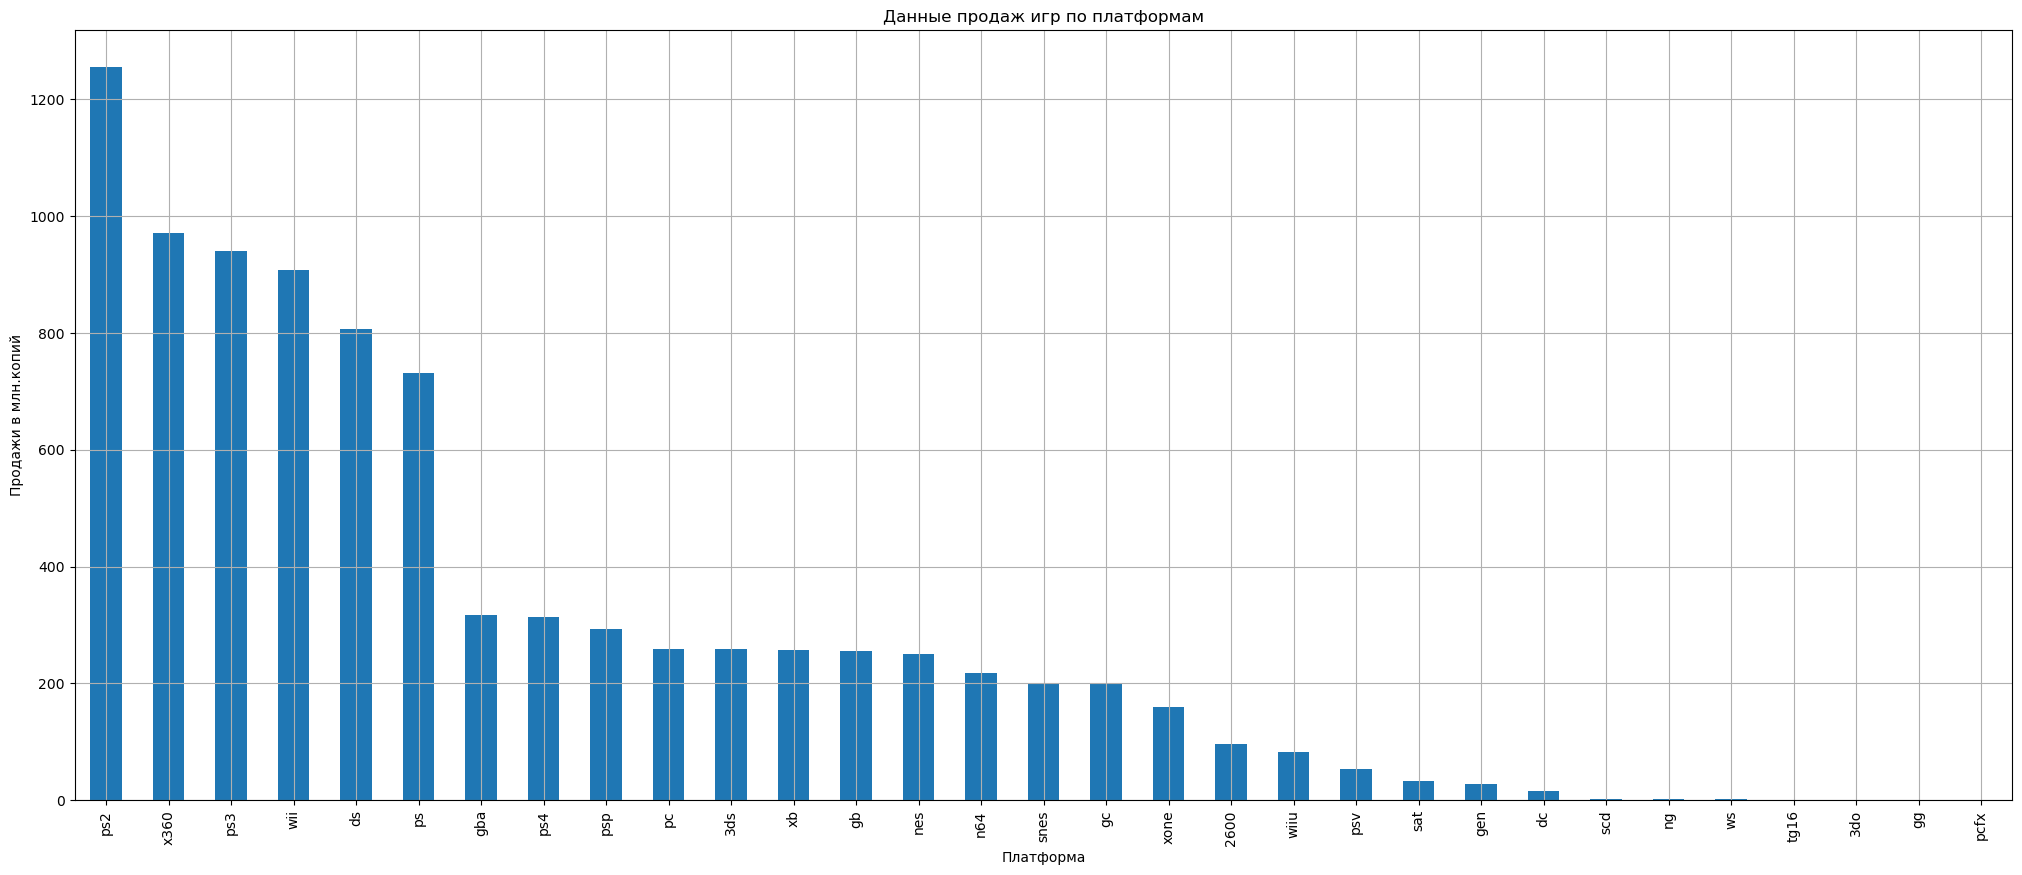

In [66]:
#Построим график с общим колличеством проданных копий по платформам
ax = platform_sales.plot.bar(y='sales', legend=False, figsize=(25, 10))
#ax.bar_label(ax.containers[0])
#В версии на платформе выдает ошибку
plt.title(label='Данные продаж игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи в млн.копий')
plt.grid(True);

Как можем заметить за все время лидерами продаж являлись такие платформы как:
- PS2 - 1255.47 млн.копий
- X360 - 970.94 млн.копий
- PS3 - 939.41 млн.копий
- Wii - 906.91 млн.копий
- DS - 805.49 млн.копий
- PS - 730.82 млн.копий

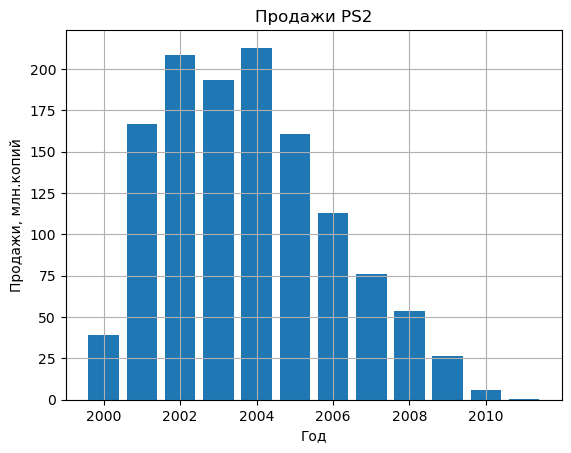

In [67]:
#Построим гистограмму 'Продажи PS2'
plt.title(label='Продажи PS2')
plt.bar(x=platform[platform['platform'] == 'ps2']['year_of_realease'], 
        height=platform[platform['platform'] == 'ps2']['sales'])
plt.xlabel('Год')
plt.ylabel('Продажи, млн.копий')
plt.grid(True);

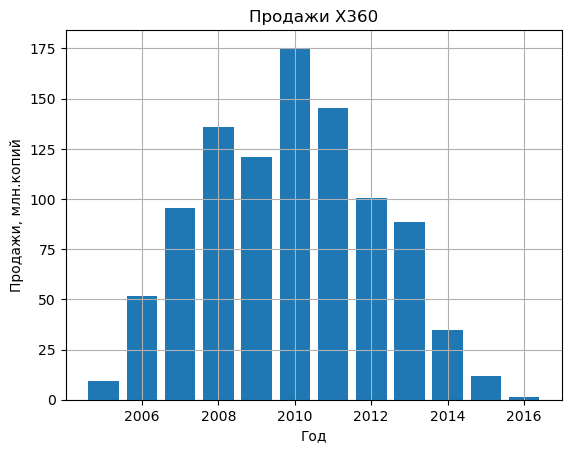

In [68]:
#Построим гистограмму 'Продажи X360'
plt.title(label='Продажи X360')
plt.bar(x=platform[platform['platform'] == 'x360']['year_of_realease'], 
        height=platform[platform['platform'] == 'x360']['sales'])
plt.xlabel('Год')
plt.ylabel('Продажи, млн.копий')
plt.grid(True);

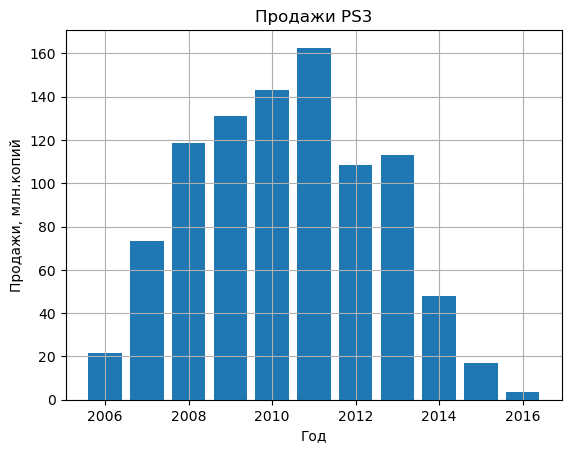

In [69]:
#Построим гистограмму 'Продажи PS3'
plt.title(label='Продажи PS3')
plt.bar(x=platform[platform['platform'] == 'ps3']['year_of_realease'], 
        height=platform[platform['platform'] == 'ps3']['sales'])
plt.xlabel('Год')
plt.ylabel('Продажи, млн.копий')
plt.grid(True);

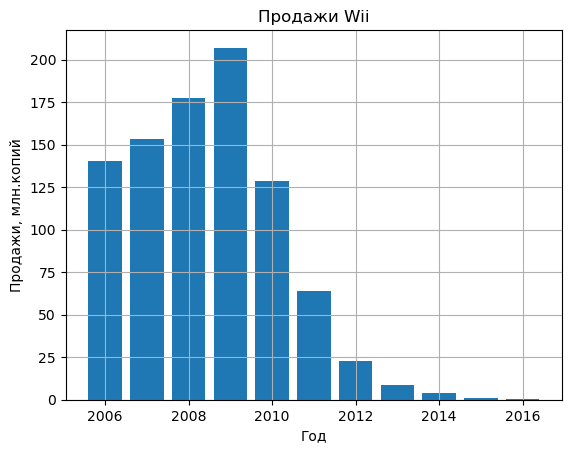

In [70]:
#Построим гистограмму 'Продажи Wii'
plt.title(label='Продажи Wii')
plt.bar(x=platform[platform['platform'] == 'wii']['year_of_realease'], 
        height=platform[platform['platform'] == 'wii']['sales'])
plt.xlabel('Год')
plt.ylabel('Продажи, млн.копий')
plt.grid(True);

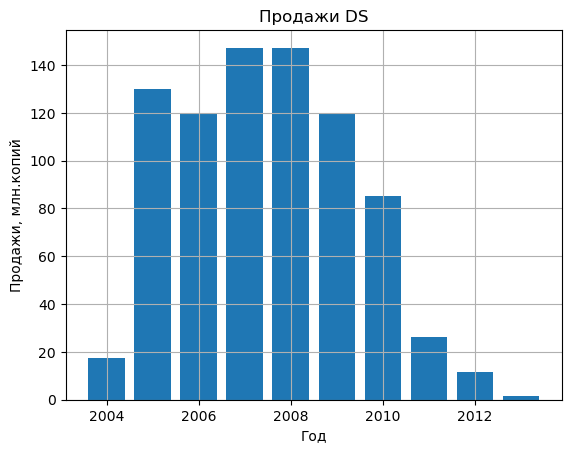

In [71]:
#Построим гистограмму 'Продажи DS'
plt.title(label='Продажи DS')
plt.bar(x=platform[platform['platform'] == 'ds']['year_of_realease'], 
        height=platform[platform['platform'] == 'ds']['sales'])
plt.xlabel('Год')
plt.ylabel('Продажи, млн.копий')
plt.grid(True);

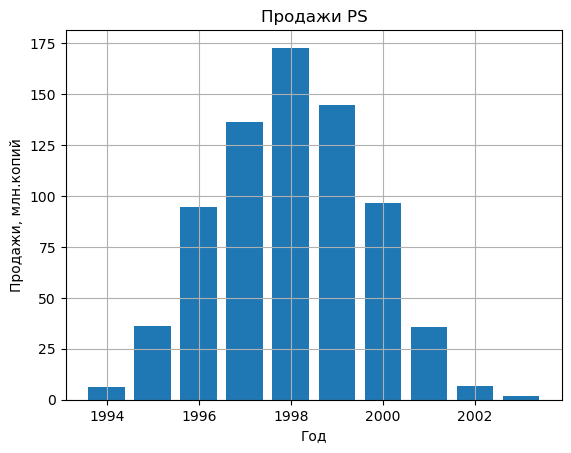

In [72]:
#Построим гистограмму 'Продажи PS'
plt.title(label='Продажи PS')
plt.bar(x=platform[platform['platform'] == 'ps']['year_of_realease'], 
        height=platform[platform['platform'] == 'ps']['sales'])
plt.xlabel('Год')
plt.ylabel('Продажи, млн.копий')
plt.grid(True);

Большинство продаж на общем графике отражено за счет прошлых лет, если рассматривать период более приближенный к 2016 году, лидерами продаж возможно будут другие платформы. Для более точных выводов необходимо рассмотреть более актуальный промежуток времени.

#### Возьмем данные за соответствующий актуальный период. Основной фактор — эти данные помогут построить прогноз на 2017 год.

In [73]:
#Определим платформы актуальные на основе последнего года продаж
platform_max = (
    platform
    .pivot_table(index='platform', 
                 values='year_of_realease', 
                 aggfunc='max'
                )
    .sort_values(by='year_of_realease', ascending=False)
    .reset_index()
)

display(platform_max)

,platform,year_of_realease
0,xone,2016
1,3ds,2016
2,x360,2016
3,wiiu,2016
4,wii,2016
5,psv,2016
6,pc,2016
7,ps4,2016
8,ps3,2016
9,psp,2015


In [74]:
#Год в котором собирались данные в последаний раз, по данным на 2016 год с общими данными
platform_max = platform_max.merge(platform, on=['platform', 'year_of_realease'], how='left')

Для анализа возьмем данные платформ актуальных на 2016 год, их 9. Последний актуальный год был представлен в таблице platform_max. 

In [75]:
#Рассмотрим данные за последние 2 года по данным платформам, актуальным на 2016 год
platform_actual = platform[(platform['platform'].isin(['wii', 'pc', 'ps4', 
                                                       'x360', 'xone', 'ps3', 
                                                       'wiiu', '3ds', 'psv']))&(platform['year_of_realease'] >= 2014)]
display(platform_actual)

,platform,year_of_realease,eu_sales,jp_sales,na_sales,other_sales,sales
15,3ds,2014,8.75,20.74,12.99,2.07,44.55
16,3ds,2015,5.06,15.52,6.17,1.03,27.78
17,3ds,2016,2.33,8.03,4.14,0.64,15.14
115,pc,2014,8.87,0.00,3.51,0.90,13.28
116,pc,2015,5.57,0.00,2.36,0.59,8.52
117,pc,2016,3.53,0.00,1.36,0.36,5.25
149,ps3,2014,18.24,6.25,16.39,6.88,47.76
150,ps3,2015,6.04,3.67,4.99,2.12,16.82
151,ps3,2016,1.26,1.30,0.67,0.37,3.60
153,ps4,2014,46.50,2.97,34.75,15.78,100.00


In [76]:
#Построим сводную таблицу для графика
platform_diagram = (platform_actual
                    .pivot_table(index='year_of_realease',columns='platform', values='sales')
                    .reset_index()
                   )
platform_diagram

platform,year_of_realease,3ds,pc,ps3,ps4,psv,wii,wiiu,x360,xone
0,2014,44.55,13.28,47.76,100.00,12.16,3.75,22.03,34.74,54.07
1,2015,27.78,8.52,16.82,118.90,6.25,1.14,16.35,11.96,60.14
2,2016,15.14,5.25,3.60,69.25,4.25,0.18,4.60,1.52,26.15


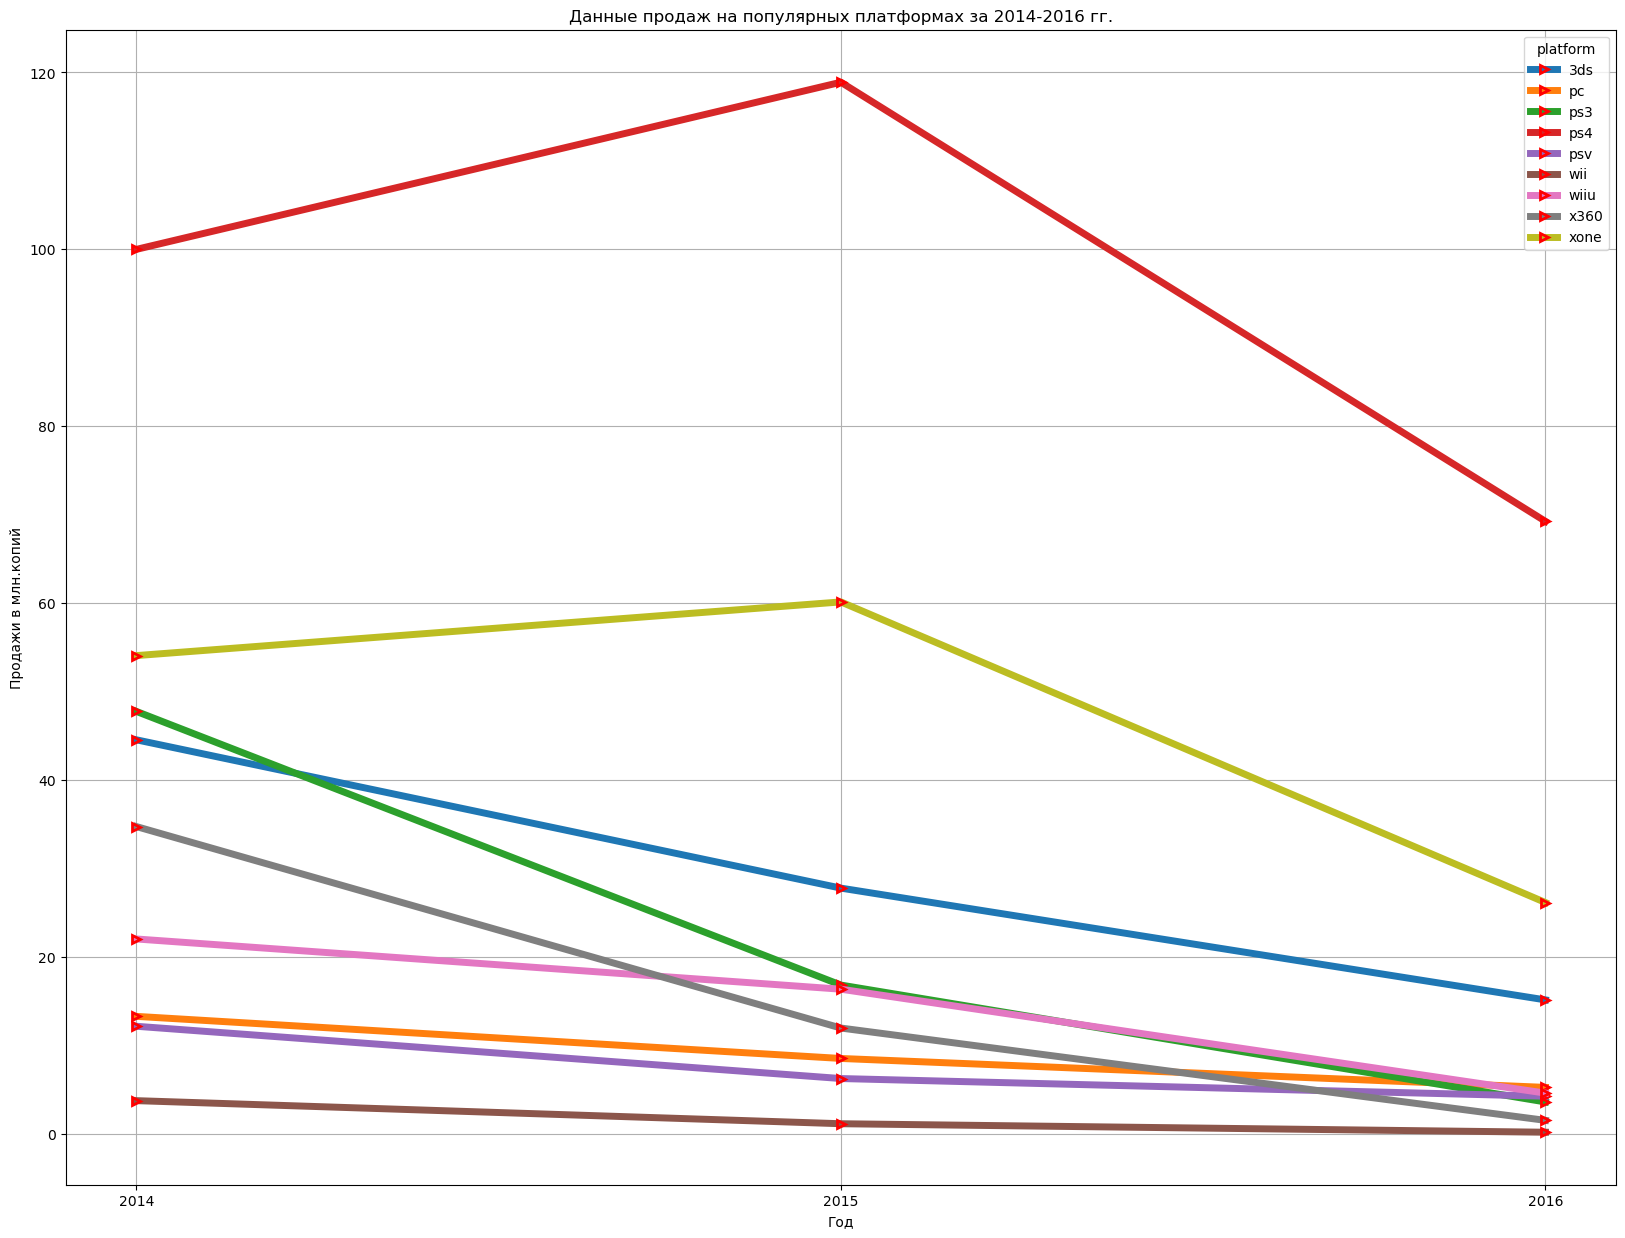

In [77]:
#Построим диаграмму
platform_diagram.plot('year_of_realease', ['3ds', 'pc', 'ps3', 'ps4', 'psv', 'wii', 'wiiu', 'x360', 'xone'], 
                      marker='>', figsize=(20, 15), lw=5, mec='r', mew=2)
plt.title(label='Данные продаж на популярных платформах за 2014-2016 гг.')
plt.xlabel('Год')
plt.ylabel('Продажи в млн.копий')
plt.grid(True)
plt.xticks([2014, 2015, 2016]);

Как можно заметить из графика динамика продаж за период 2014-2016гг. на разных платформах сильно отличается.

- Wii до 2015 года имеет тенденцию к уменьшению продаж.
- PC имеет плавную тенденцию к уменьшению продаж.
- PS4 с момента выхода на рынок в 2013 году имеет восходящую тенденцию, что показано на графике за период с 2014 до 2015 года, среди всех платформ за анализируемый период имеет максимальные показатели продаж. По уже имеющимся результатам за 2016 год, также возглавляет список платформ.
- X360 за период 2014-2015гг имеет тенденцию к уменьшению продаж.
- XOne имеет восходящую тенденцию, на графике представлена за период 2014-2015гг, данная платформа лидирует по количеству проданных копий, сразу после уже отмеченной платформой PS4.
- PS3 за анализируемый период имеет тенденцию к уменьшению продаж.
- WiiU имеет плавный график и тенденцию к уменьшению продаж.
- 3DS за анализируемый период имеет тенденцию к уменьшению продаж.
- PSV за анализируемый период имеет стабильную тенденцию к уменьшению.

По данные графика можно сказать, что анализируемый период 2014-2015гг и беря во внимание данные за начало 2016г, только у двух платформ наблюдается восходящая тенденция: PS4 и XOne, также данные платформы являются самыми прибыльными.

На основе вышеизложенного наиболее перспективными платформами на 2017 год по имеющимся данным являются PS4 и XOne, данные платформы рекомендуемы маркетологам компании.

Так же к рекомендуемым платформам можно отнести те, чьи продажи были достаточны высоки и угол наклонной на графике не очень большой или же продажи обусловлены многолетним удачным опытом продаж.
К таким платформам можно отнести 3DS, которая заняла 3-е место по количеству проданных копий в 2015 году (~27 млн.копий). Также платформа PC может быть представлена отделу маркетнга, так как зарекомендовала себя как устойчивая платформа по продажам в данной индустрии.

Платформы PS3 и WiiU за 2015 год имеют ~18 млн. проданных копий, что также может быть предложено отделу маркетинга на рассмотрение.

#### Не будем учитывать в работе данные за предыдущие годы.

In [78]:
#Отберем данные за 2015 год
data_sorted = data[data['year_of_realease'].isin([2015])].sort_values(by='sales', ascending=False)

In [79]:
data_sorted

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,categorize_rating,sales
31,call of duty: black ops 3,ps4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,RP,RP,14.63
77,fifa 16,ps4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,E,8.58
87,star wars battlefront (2015),ps4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,RP,RP,7.98
99,call of duty: black ops 3,xone,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,RP,RP,7.39
105,fallout 4,ps4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,M,7.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16216,fuuraiki 3,psv,2015,Action,0.00,0.00,0.01,0.00,NaN,NaN,RP,RP,0.01
16238,nhl 16,ps3,2015,Sports,0.00,0.01,0.00,0.00,NaN,NaN,RP,RP,0.01
16267,hyakka yakou,psv,2015,Action,0.00,0.00,0.01,0.00,NaN,NaN,RP,RP,0.01
16297,barbie and her sisters puppy rescue,wiiu,2015,Action,0.00,0.01,0.00,0.00,NaN,2.8,E,E,0.01


In [80]:
#Преобразуем данные для графика
sales_sorted = (data_sorted
                .pivot_table(index='platform', values='sales', aggfunc='sum')
                .sort_values(by='sales', ascending=False)
                .reset_index()
               )

display(sales_sorted)

,platform,sales
0,ps4,118.90
1,xone,60.14
2,3ds,27.78
3,ps3,16.82
4,wiiu,16.35
5,x360,11.96
6,pc,8.52
7,psv,6.25
8,wii,1.14
9,psp,0.12


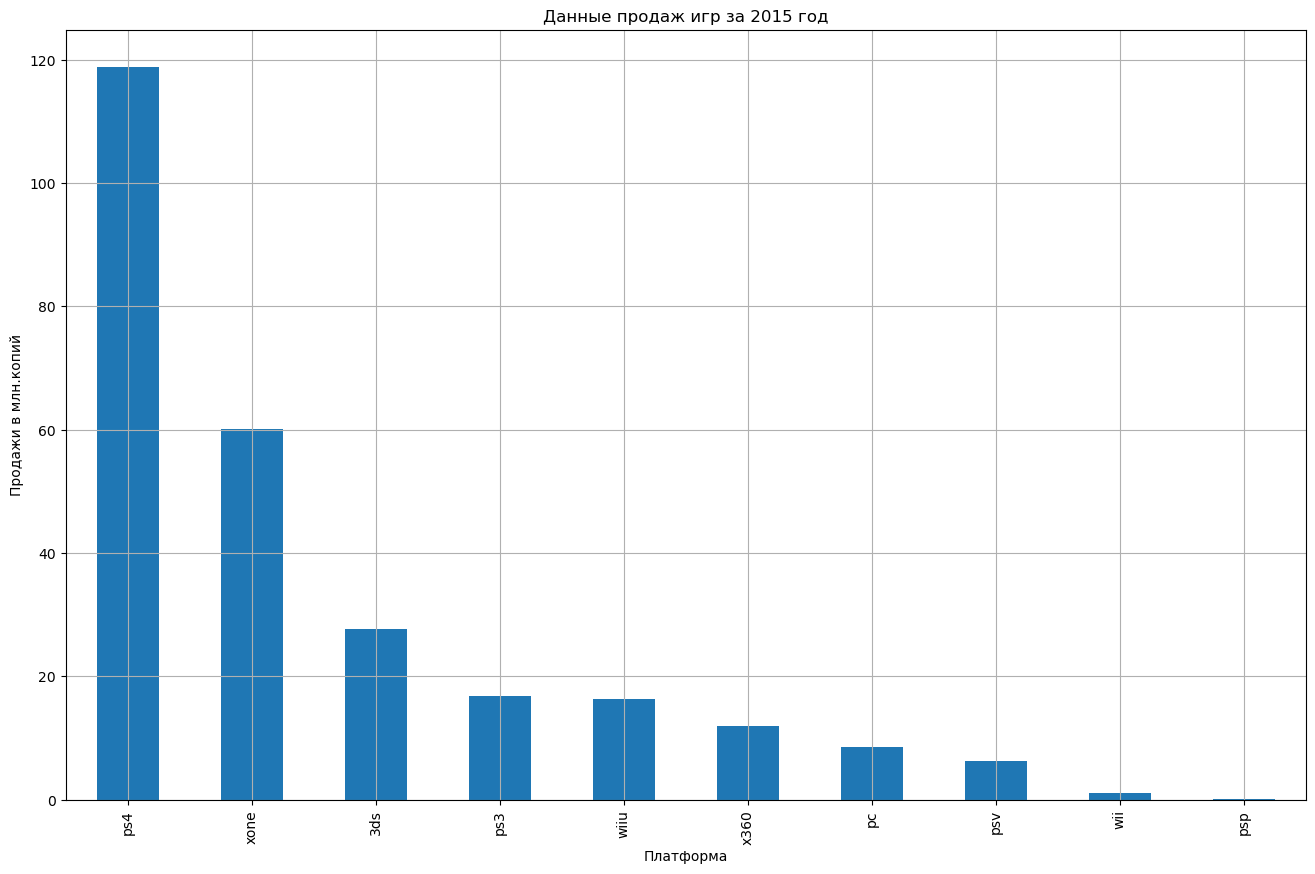

In [81]:
#Выведем данные по продажам игр на 2015 год
ax = sales_sorted.plot.bar (x='platform', y='sales', legend=False, figsize=(16, 10))
#ax.bar_label (ax.containers[0])
#В версии на платформе выдает ошибку
plt.title(label='Данные продаж игр за 2015 год')
plt.xlabel('Платформа')
plt.ylabel('Продажи в млн.копий')
plt.grid(True);

За период 2015 год год лидером продаж являлась платформа PS4. Суммарно за данный период продажи составили 118.90 млн. копий.

- PS4 с момента выхода на рынок в 2013 году имеет восходящую тенденцию, за период 2014-2015гг наблюдался рост продаж, также данная платформа на протяжении всего актуального анализируемого срока являлась лидером продаж.

На 2016 год поддержка активна. Является потенциально выгодной платформой.

- XOne аналогично PS4 за анализируемый период времени имеет восходящую тенденцию, наблюдается, что данная платформа за 2015 год имеет продажи в два раза ниже чем ее более конкурент.

На 2016 год поддержка активна. Является потенциально выгодной платформой.

- Для платформ 3DS, WiiU, PS3 за анализируемый период наблюдается спад продаж, возможной причиной может быть срок жизни платформ, платформы вытесняются более крупными и перспективными конкурентами.


#### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

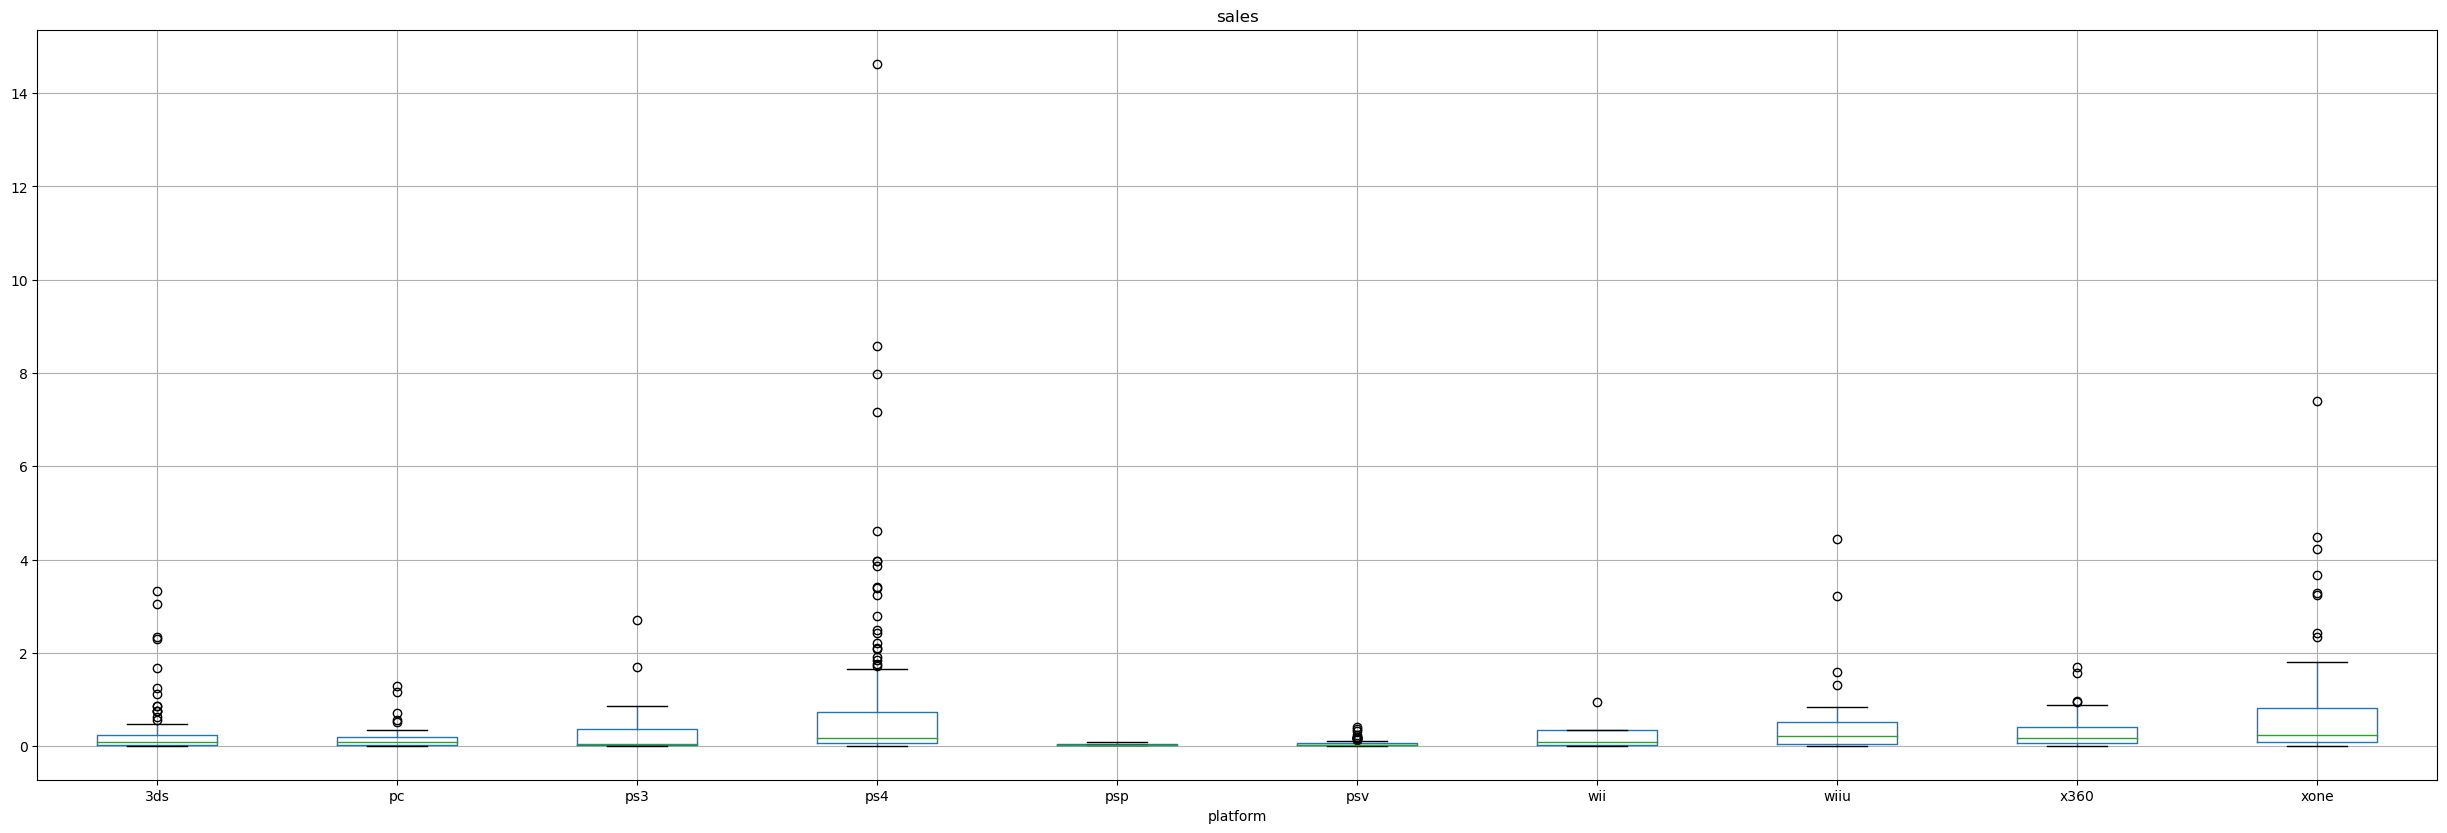

In [82]:
#boxplot в разбивке по платформам
data_sorted.boxplot('sales', by='platform', figsize=(30,10))
plt.suptitle('');

In [83]:
diag_plat_sorted = data_sorted[data_sorted['sales'] < 1.4]

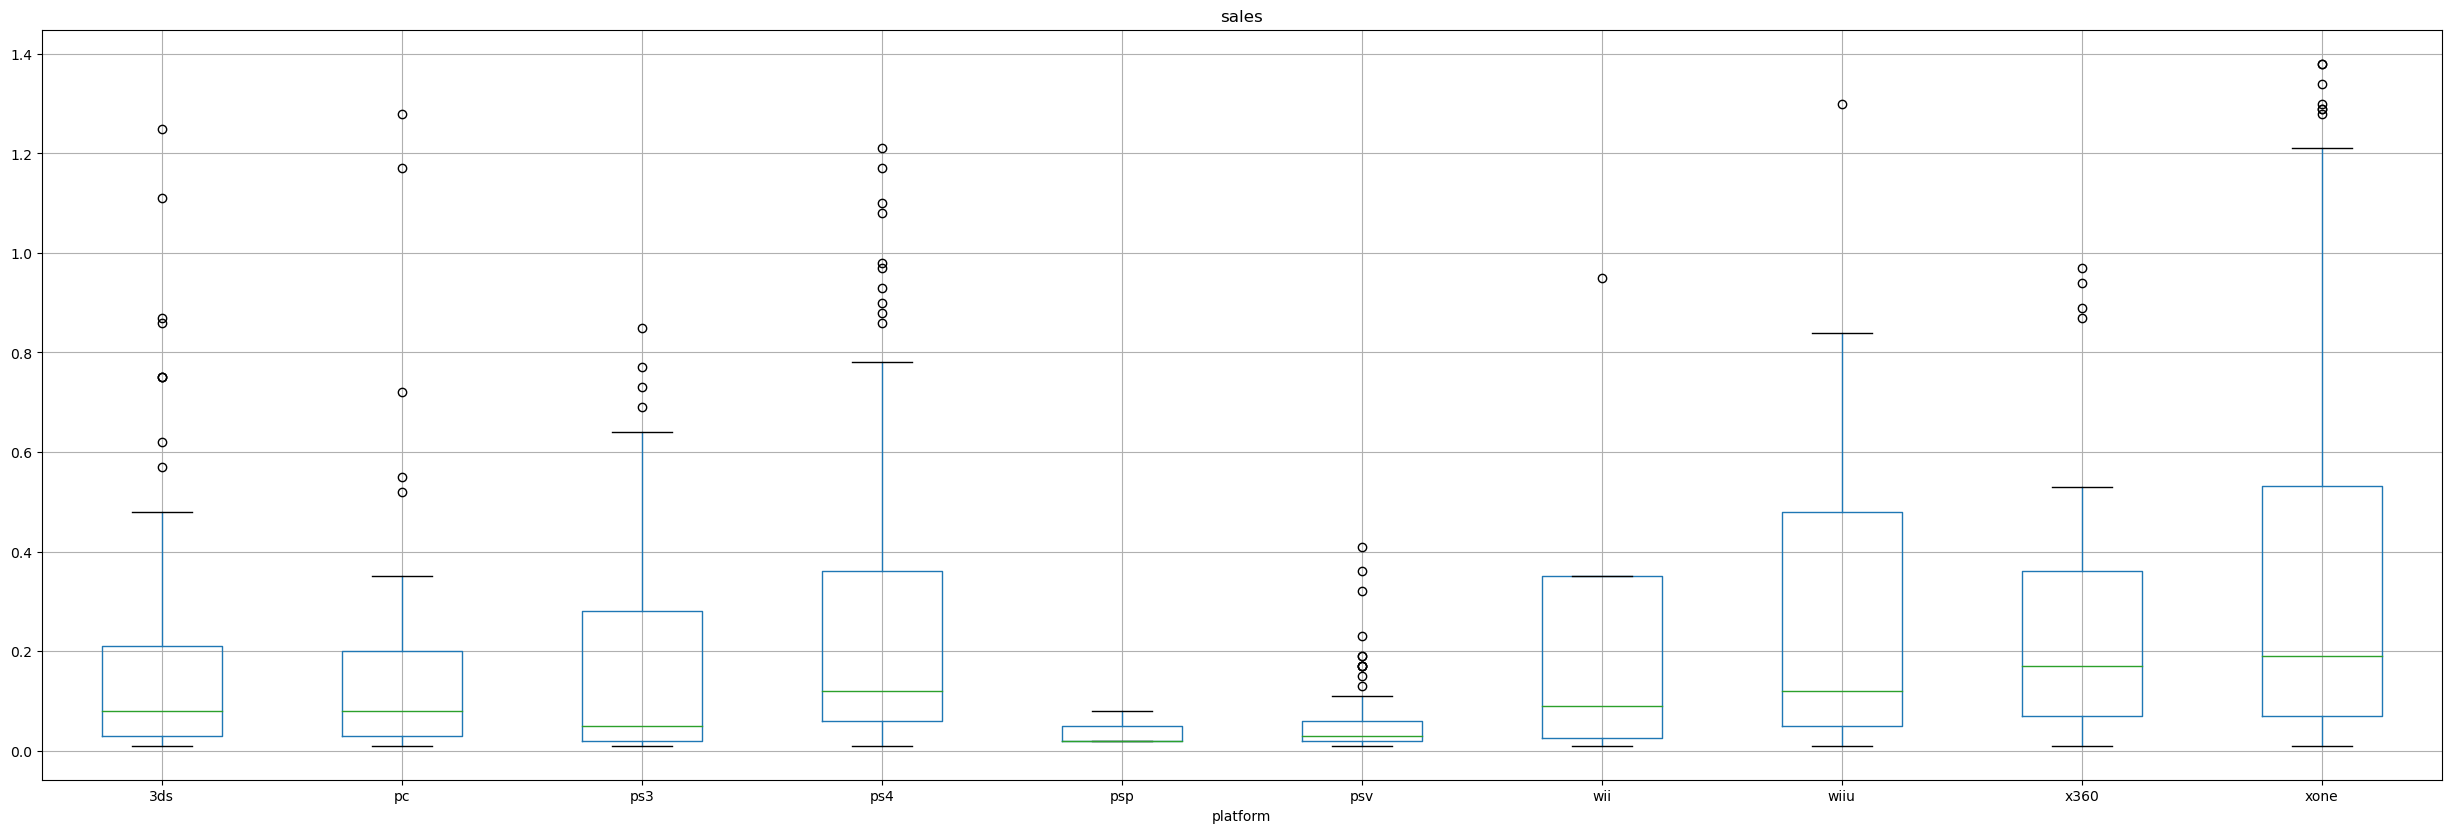

In [84]:
#boxplot в разбивке по платформам исключая большую часть аномалий
diag_plat_sorted.boxplot('sales', by='platform', figsize=(30,10))
plt.suptitle('');

По данному графику можно сказать, PS4 обладает самым большим числом аномалий по количеству проданных копий, самая крайняя точка за 2015 год это примерно 14,6 млн. копий продажи игры "call of duty: black ops 3" при среднем значении равном примерно 0,8 млн копий. Следующая платформа по отклонению от среднего количества продаж - XOne. Для платформы XOne характерен более широкий межквартильный размах, чем у PS4. При этом среднее значение продаж у XOne больше, вместе с информацией об отклонении можно предположить, что для данной платформы хакрактерна продажа более стабильных в своей популярности и качестве игр.

Также по графику можно сказать что для платформы PSP в 2015 году продаж практически не было, либо были, но небольшие и не имеющие слишком большой популярности у пользователей.

Для всех остальных платформ характерно наличие аномалий, но с разной степенью разброса, также по графику видно смещение средней к линии 25%-квантиля, что лишь свидетельствует о сильном влиянии аномалий на показатели продаж.

#### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 

In [85]:
#Определим данные для графика, рассмотрим платфоорму PS4 (имеется в выборке за актуальный период)
PS4 = data_sorted[data_sorted['platform'] == 'ps4']
display(PS4.head())

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,categorize_rating,sales
31,call of duty: black ops 3,ps4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,RP,RP,14.63
77,fifa 16,ps4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,E,8.58
87,star wars battlefront (2015),ps4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,RP,RP,7.98
105,fallout 4,ps4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,M,7.17
231,uncharted: the nathan drake collection,ps4,2015,Action,2.07,1.71,0.08,0.76,86.0,8.1,T,T,4.62


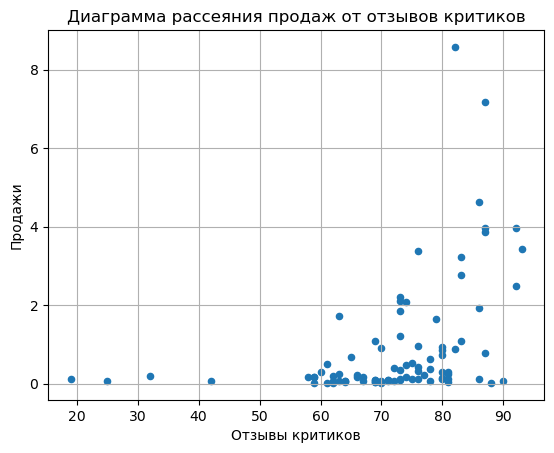

In [86]:
#Построим диаграмму рассеяния на примере PS4
PS4.plot.scatter (x = 'critic_score', y = 'sales')
plt.title(label='Диаграмма рассеяния продаж от отзывов критиков')
plt.xlabel('Отзывы критиков')
plt.ylabel('Продажи')
plt.grid(True);

In [87]:
#Рассчитаем коэффициент корреляции
round((PS4['critic_score'].corr(PS4['sales'])),2)

0.41

По данным диаграммы рассеяния и коэффициента корреляции можно предположить, что количество проданных копий умеренно зависит от оценки критика и соотношение является прямо пропорциональным. То есть на решение о покупке игры с достаточной долей вероятности будет играть оценка критика.

Причиной таких результатов может служить ограниченность значений. Для более точных выводов о влиянии разных факторов на продажи недостаточно данных.

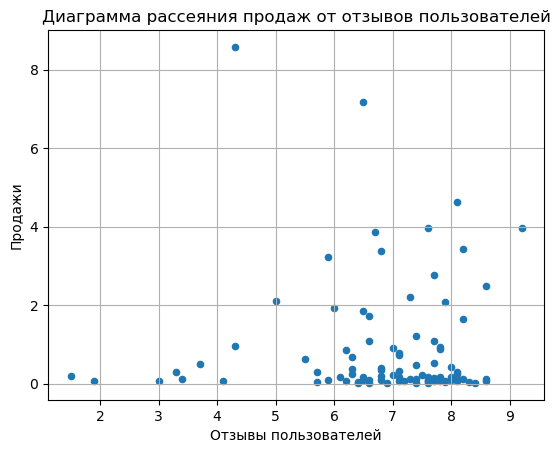

In [88]:
#Построим диаграмму рассеяния
PS4.plot.scatter (x = 'user_score', y = 'sales')
plt.title(label='Диаграмма рассеяния продаж от отзывов пользователей')
plt.xlabel('Отзывы пользователей')
plt.ylabel('Продажи')
plt.grid(True);

In [89]:
#Рассчитаем коэффициент корреляции
round((PS4['user_score'].corr(PS4['sales'])),3)

-0.002

По данным диаграммы рассеяния и коэффициента корреляции можно предположить вывод, что количество проданных копий слабо зависит от оценки пользователей. Данный вывод выглядит неправдоподобно, для более детальной оценки нужны дополнительные данные, так как на выбор покупателей могут влиять другие сопутствующие факторы.

#### Соотнесем выводы с продажами игр на других платформах.

In [90]:
#Определим данные для графика, рассмотрим платфоорму XOne (имеется в выборке за актуальный период)
XOne = data_sorted[data_sorted['platform'] == 'xone']
display(XOne.head())

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,categorize_rating,sales
99,call of duty: black ops 3,xone,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,RP,RP,7.39
242,halo 5: guardians,xone,2015,Shooter,2.78,1.27,0.03,0.41,84.0,6.4,T,T,4.49
270,fallout 4,xone,2015,Role-Playing,2.51,1.32,0.01,0.38,88.0,6.2,M,M,4.22
342,star wars battlefront (2015),xone,2015,Shooter,2.04,1.28,0.02,0.32,NaN,NaN,RP,RP,3.66
413,gears of war: ultimate edition,xone,2015,Shooter,2.61,0.33,0.00,0.34,82.0,7.5,M,M,3.28


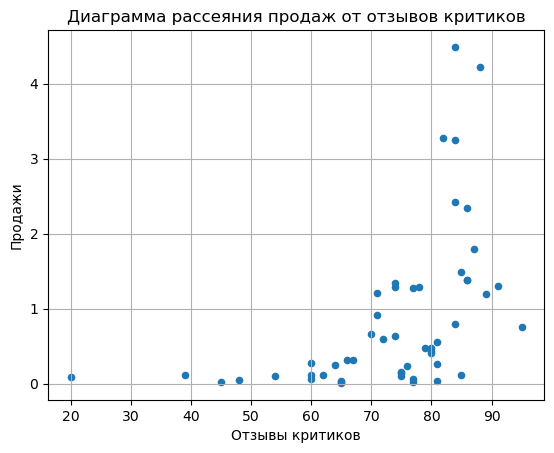

In [91]:
#Построим диаграмму рассеяния на примере XOne
XOne.plot.scatter (x = 'critic_score', y = 'sales')
plt.title(label='Диаграмма рассеяния продаж от отзывов критиков')
plt.xlabel('Отзывы критиков')
plt.ylabel('Продажи')
plt.grid(True);

In [92]:
#Рассчитаем коэффициент корреляции
round((XOne['critic_score'].corr(XOne['sales'])),2)

0.49

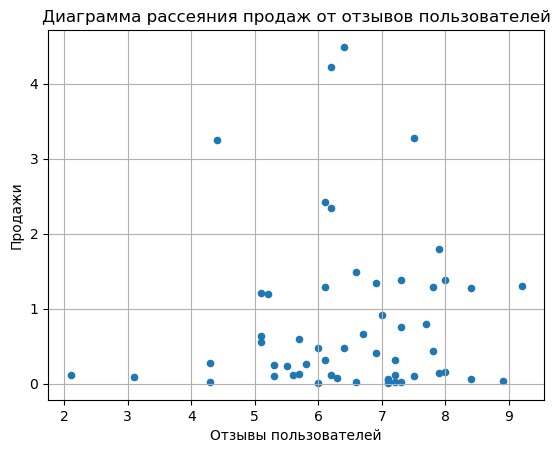

In [93]:
#Построим диаграмму рассеяния
XOne.plot.scatter (x = 'user_score', y = 'sales')
plt.title(label='Диаграмма рассеяния продаж от отзывов пользователей')
plt.xlabel('Отзывы пользователей')
plt.ylabel('Продажи')
plt.grid(True);

In [94]:
#Рассчитаем коэффициент корреляции
round((XOne['user_score'].corr(XOne['sales'])),2)

0.04

Данные за анализируемый период для платформы XOne аналогичны PS4. По полученным данным на продажи в большей степени влияет отзыв критика, отзывы пользователей практически не отражаются на продажи игр. Возможной причиной такого расходжения может быть мнение о субъетивности оценок других пользователей, а также репутация критиков как специалистов может влиять на выбор покупателя.

Достаточно много игр с высокой оценкой критиков и слабой выручкой, для проверки и более точечного анализа требуется дополнительная информация.

In [95]:
#Определим данные для графика, рассмотрим платфоорму 3DS (имеется в выборке за актуальный период)
plat_3DS = data_sorted[data_sorted['platform'] == '3ds']
display(plat_3DS.head())

,name,platform,year_of_realease,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,categorize_rating,sales
406,monster hunter x,3ds,2015,Action,0.27,0.21,2.79,0.05,NaN,NaN,RP,RP,3.32
457,animal crossing: happy home designer,3ds,2015,Simulation,0.51,1.02,1.40,0.12,66.0,6.9,E,E,3.05
676,the legend of zelda: majora's mask 3d,3ds,2015,Action,1.15,0.55,0.47,0.17,89.0,9.0,E10+,E10+,2.34
693,yokai watch busters,3ds,2015,Action,0.00,0.00,2.29,0.00,NaN,NaN,RP,RP,2.29
1078,fire emblem fates,3ds,2015,Role-Playing,0.81,0.23,0.52,0.11,NaN,NaN,RP,RP,1.67


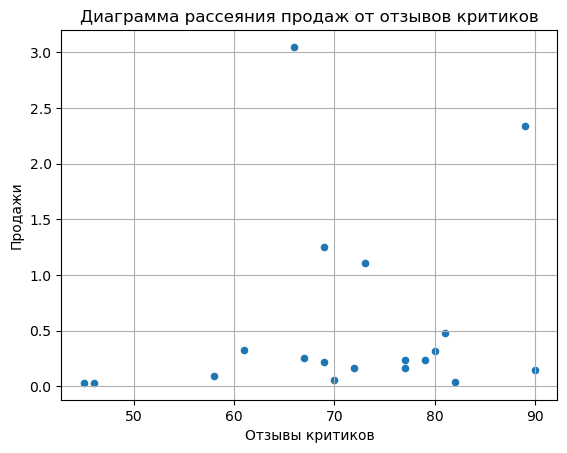

In [96]:
#Построим диаграмму рассеяния на примере 3DS
plat_3DS.plot.scatter (x = 'critic_score', y = 'sales')
plt.title(label='Диаграмма рассеяния продаж от отзывов критиков')
plt.xlabel('Отзывы критиков')
plt.ylabel('Продажи')
plt.grid(True);

In [97]:
#Рассчитаем коэффициент корреляции
round((plat_3DS['critic_score'].corr(plat_3DS['sales'])),2)

0.18

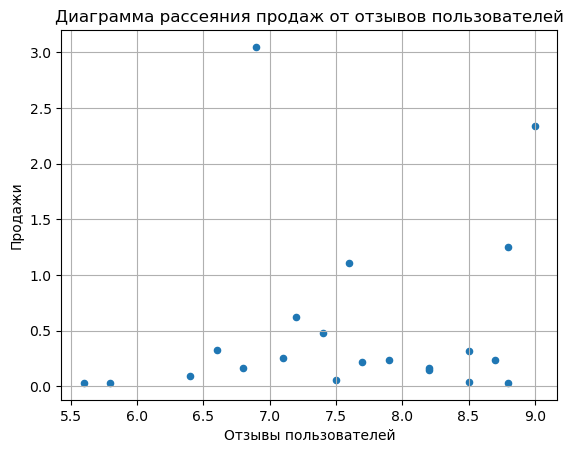

In [98]:
#Построим диаграмму рассеяния
plat_3DS.plot.scatter (x = 'user_score', y = 'sales')
plt.title(label='Диаграмма рассеяния продаж от отзывов пользователей')
plt.xlabel('Отзывы пользователей')
plt.ylabel('Продажи')
plt.grid(True);

In [99]:
#Рассчитаем коэффициент корреляции
round((plat_3DS['user_score'].corr(plat_3DS['sales'])),2)

0.16

Для платформы 3DS отзывы критиков и пользователей за актуальный промежуток времени в равной степени малы. То есть на выбор покупателя может влиять другой более значимый фактор. Также стоит отметить, что хоть платформа и находится в списке самых прибыльных за период 2015г, она "старше" вышеуказанных, что может говорить о другой целевой аудитории.

Низкий показатель может быть причиной недостаточности данных. Для более точных результатов требутся дополнительная информация.

#### Посмотрим на общее распределение игр по жанрам. 

In [100]:
#Рассмотрим жанры игр и их количество
data_sorted['genre'].value_counts()

Action          253
Role-Playing     78
Sports           59
Adventure        54
Misc             39
Shooter          34
Fighting         21
Racing           18
Strategy         16
Simulation       15
Platform         13
Puzzle            6
Name: genre, dtype: int64

Рынок игр больше насыщен динамичными сюжетами, таких жанров достаточно много, например Action, Role-Playing, Sports, Shooter, при этом среднее количество игр данных жанров отличается. Количество в жанре Shooter и Sports	в значительной степени превышает среднюю по рынку, когда как Puzzle и Strategy являются одними из самых нераспространенных и менее продаваемых.

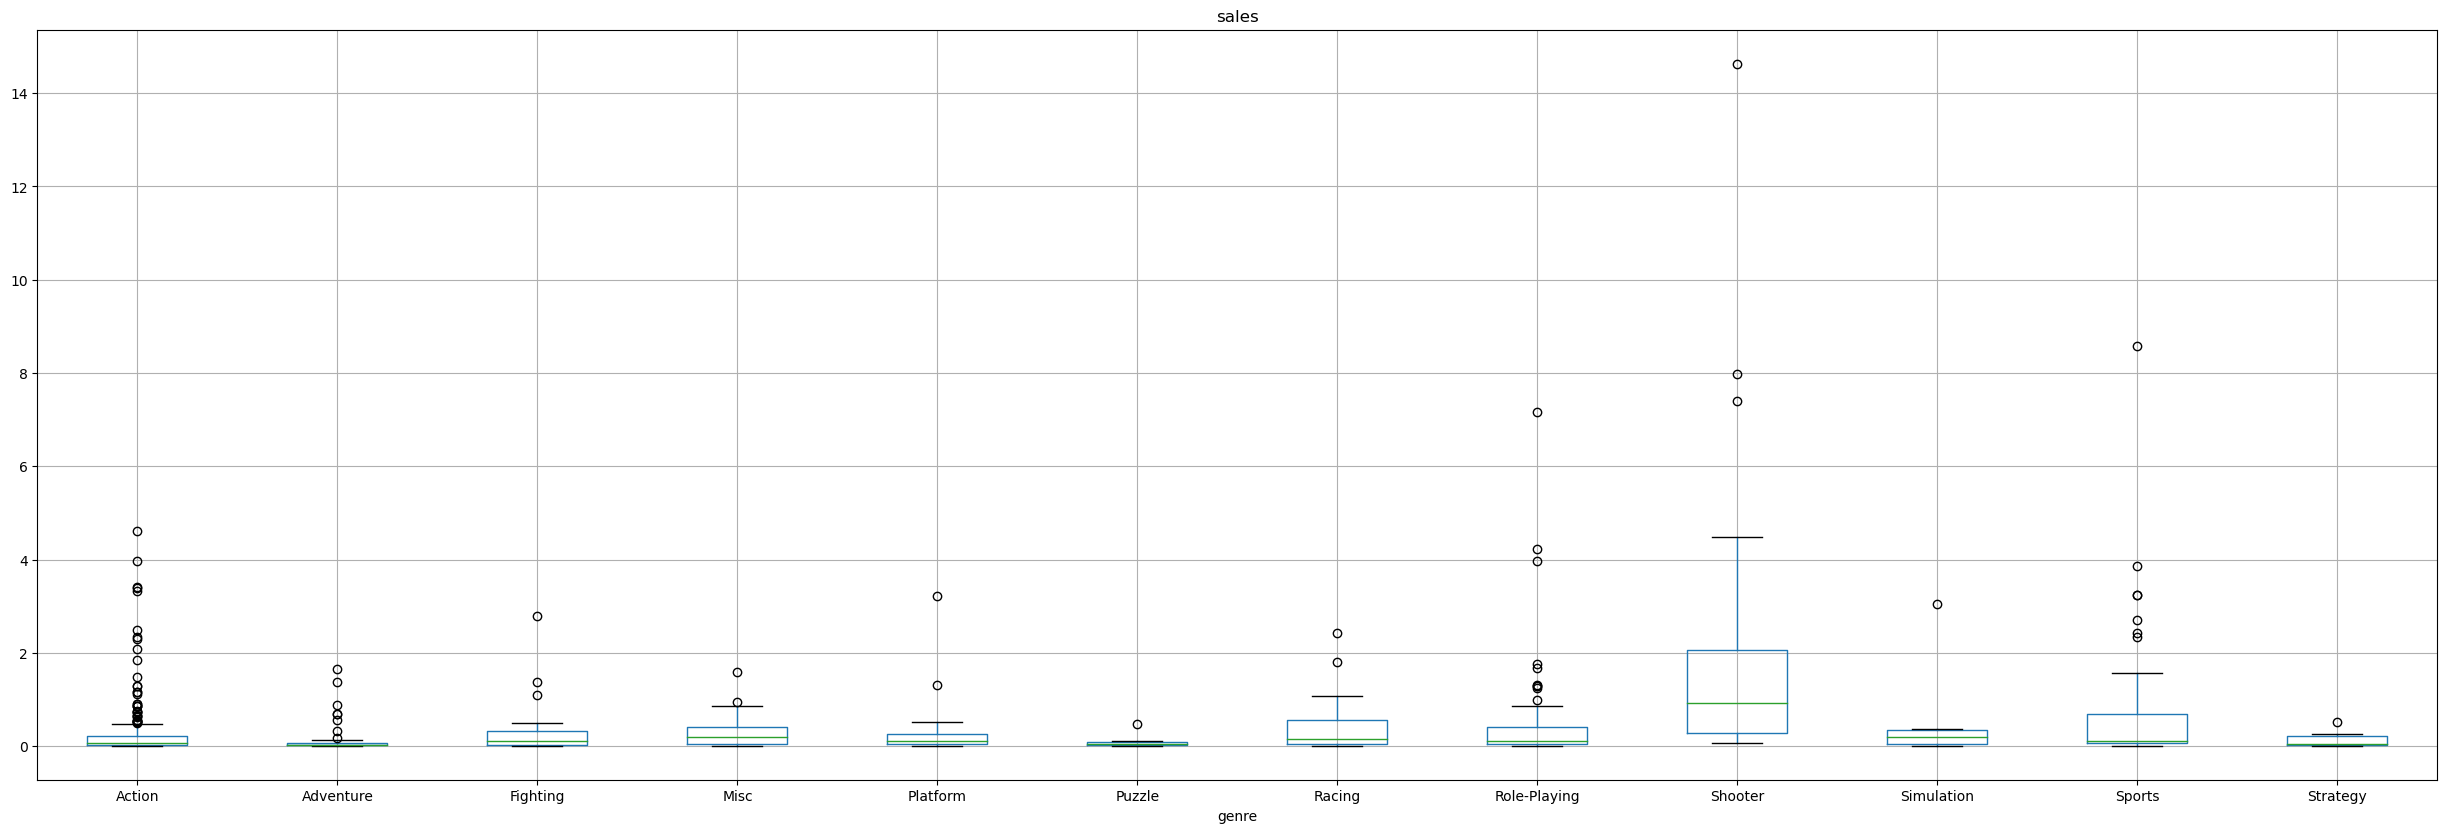

In [101]:
#boxplot в разбивке по жанрам
data_sorted.boxplot('sales', by='genre', figsize=(30,10))
plt.suptitle('');

In [102]:
data_sorted['sales'].describe()

count    606.000000
mean       0.442211
std        1.099421
min        0.010000
25%        0.030000
50%        0.090000
75%        0.357500
max       14.630000
Name: sales, dtype: float64

In [103]:
#Необходимо исключить аномалии
diag_sales_sorted = data_sorted[data_sorted['sales'] <2]

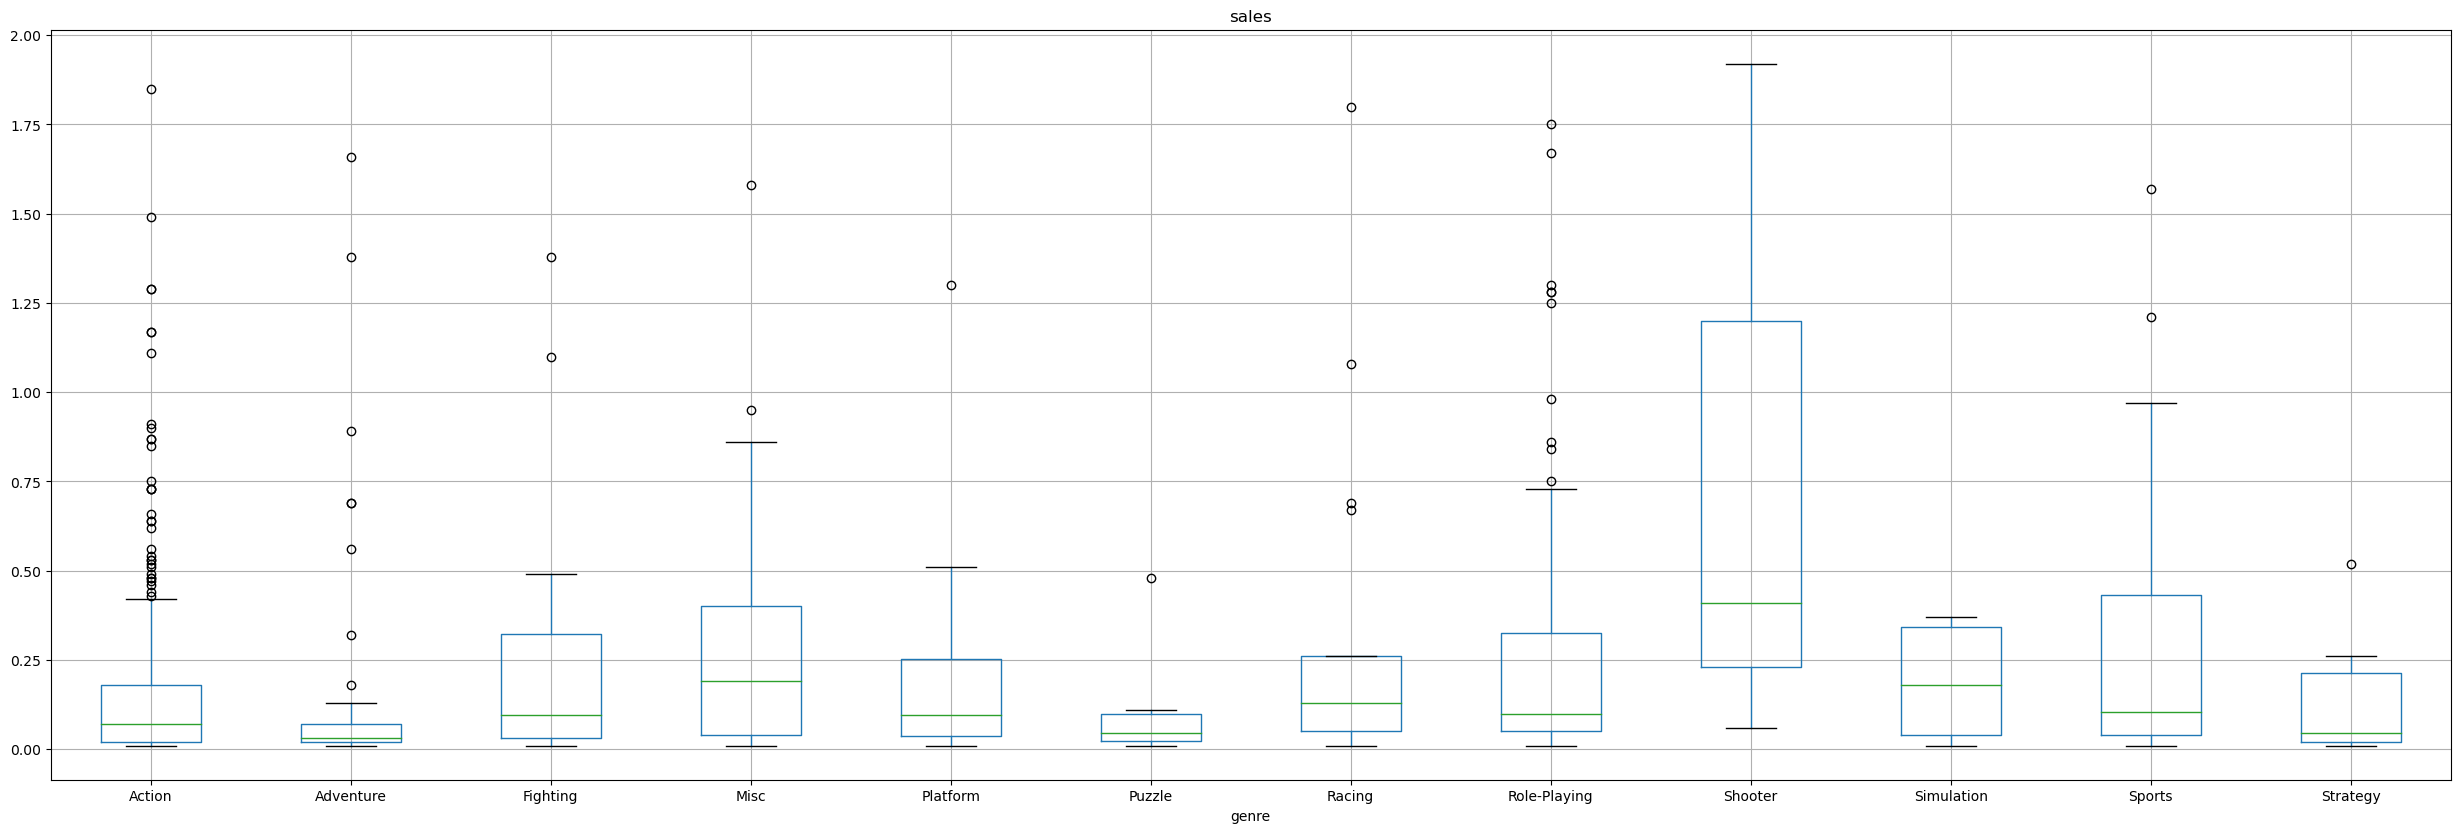

In [104]:
#boxplot в разбивке по жанрам
diag_sales_sorted.boxplot('sales', by='genre', figsize=(30,10))
plt.suptitle('');

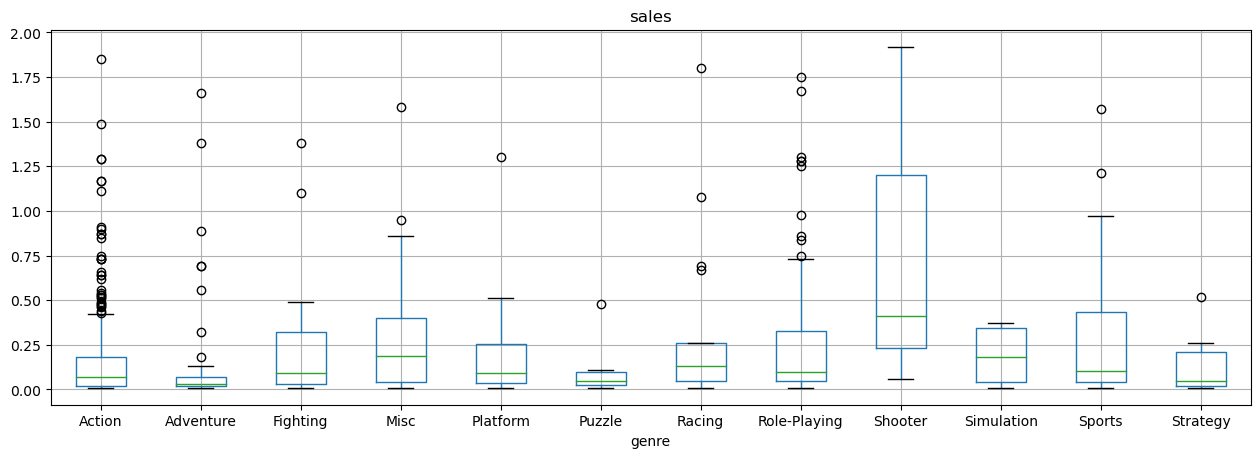

In [105]:
# увеличим масштаб

diag_sales_sorted.boxplot('sales', by='genre', figsize=(15,5))
plt.suptitle('');

Жанр с самыми большими продажами - Shooter, даже при условии небольшого количества игр за 2015г на грфике представлен самый большой межквартильный размах, что говорит о разбросе данных. Соотношение относительно небольшого количества игр к продажам может быть причиной широкой популярности данного жанра. 

Самыми устойчивыми на рынке являются жанры медианная которых при разных условиях разброса аномальных величин будет принадлежать промежутку от 0,25-квантиля до 0,75-квантиля.
За анлизируемый период самыми стабильными являются жанры Adventure и Puzzle. Данные жанры в меньшей степени чем остальные зависят от временной популярности, актуальности. Раззброс данных минимален, но все равно наблюдаются выбросы, что при достаточно объемном количестве данных не сильно влияет на среднюю и межквартильный размах.

Остальные жанры в большей степени подвержены временным колебаниям разных факторов.

### Шаг 4. Составим портрет пользователя каждого региона

#### Определим для пользователя каждого региона (NA, EU, JP): Самые популярные платформы (топ-5). 

In [106]:
#Ограничим данные за период 2015 год
platform_region = (platform[platform['year_of_realease'].isin([2015])]
                  .pivot_table(index='platform', 
                               values=(['eu_sales', 'jp_sales', 'na_sales', 'other_sales', 'sales']), 
                               aggfunc='sum')
                  .sort_values(by='sales', ascending=False).head(50)
                 )

In [107]:
platform_region['na_sales'].sum()

106.86000000000001

In [108]:
#Процент продаж по региону от всех продаж
platform_region['percent_na'] = platform_region['na_sales'] / platform_region['na_sales'].sum()
platform_region['percent_eu'] = platform_region['eu_sales'] / platform_region['eu_sales'].sum()
platform_region['percent_jp'] = platform_region['jp_sales'] / platform_region['jp_sales'].sum()

In [109]:
other = {'platform' : 'other', 'eu_sales' : '', 'jp_sales' : '', 'na_sales' : '', 'other_sales' : '',
        'sales' : '', 'percent_na' : '', 'percent_eu' : '', 'percent_jp' : ''}

In [110]:
(platform_region
             .sort_values(by='na_sales', ascending=False)
             .reset_index()
            )

,platform,eu_sales,jp_sales,na_sales,other_sales,sales,percent_na,percent_eu,percent_jp
0,ps4,51.76,6.31,42.37,18.46,118.90,0.396500,0.535153,0.185098
1,xone,18.47,0.17,36.03,5.47,60.14,0.337170,0.190964,0.004987
2,x360,3.50,0.00,7.36,1.10,11.96,0.068875,0.036187,0.000000
3,wiiu,5.01,3.45,6.76,1.13,16.35,0.063260,0.051799,0.101203
4,3ds,5.06,15.52,6.17,1.03,27.78,0.057739,0.052316,0.455265
5,ps3,6.04,3.67,4.99,2.12,16.82,0.046697,0.062448,0.107656
6,pc,5.57,0.00,2.36,0.59,8.52,0.022085,0.057589,0.000000
7,wii,0.62,0.00,0.43,0.09,1.14,0.004024,0.006410,0.000000
8,psv,0.69,4.85,0.39,0.32,6.25,0.003650,0.007134,0.142270
9,psp,0.00,0.12,0.00,0.00,0.12,0.000000,0.000000,0.003520


In [111]:
(platform_region
             .sort_values(by='na_sales', ascending=False)
             .reset_index()
            ).loc[5]

platform            ps3
eu_sales           6.04
jp_sales           3.67
na_sales           4.99
other_sales        2.12
sales             16.82
percent_na     0.046697
percent_eu     0.062448
percent_jp     0.107656
Name: 5, dtype: object

In [112]:
#Самые популярные платформы за период 2015 год для региона NA
region_na = (platform_region
             .sort_values(by='na_sales', ascending=False)
             .reset_index()
            )
region_na = region_na.append(other, ignore_index=True)
region_na.loc[10] = region_na.loc[5] + region_na.loc[6] +\
region_na.loc[7] + region_na.loc[8] + region_na.loc[9]
region_na.loc[10, 'platform'] = 'other'

region_na = region_na.sort_values(by='na_sales', ascending=False).head(6)
region_na

,platform,eu_sales,jp_sales,na_sales,other_sales,sales,percent_na,percent_eu,percent_jp
0,ps4,51.76,6.31,42.37,18.46,118.9,0.3965,0.535153,0.185098
1,xone,18.47,0.17,36.03,5.47,60.14,0.33717,0.190964,0.004987
10,other,12.92,8.64,8.17,3.12,32.85,0.076455,0.133581,0.253447
2,x360,3.5,0.0,7.36,1.1,11.96,0.068875,0.036187,0.0
3,wiiu,5.01,3.45,6.76,1.13,16.35,0.06326,0.051799,0.101203
4,3ds,5.06,15.52,6.17,1.03,27.78,0.057739,0.052316,0.455265


In [113]:
#Самые популярные платформы за период 2015 год для региона EU
region_eu = (platform_region
             .sort_values(by='eu_sales', ascending=False)
             .reset_index()
            )
region_eu = region_eu.append(other, ignore_index=True)
region_eu.loc[10] = region_eu.loc[5] + region_eu.loc[6] +\
region_eu.loc[7] + region_eu.loc[8] + region_eu.loc[9]
region_eu.loc[10, 'platform'] = 'other'

region_eu = region_eu.sort_values(by='eu_sales', ascending=False).head(6)
region_eu

,platform,eu_sales,jp_sales,na_sales,other_sales,sales,percent_na,percent_eu,percent_jp
0,ps4,51.76,6.31,42.37,18.46,118.9,0.3965,0.535153,0.185098
1,xone,18.47,0.17,36.03,5.47,60.14,0.33717,0.190964,0.004987
10,other,9.82,8.42,14.94,2.64,35.82,0.139809,0.10153,0.246993
2,ps3,6.04,3.67,4.99,2.12,16.82,0.046697,0.062448,0.107656
3,pc,5.57,0.0,2.36,0.59,8.52,0.022085,0.057589,0.0
4,3ds,5.06,15.52,6.17,1.03,27.78,0.057739,0.052316,0.455265


In [114]:
#Самые популярные платформы за период 2015 год для региона JP
region_jp = (platform_region
             .sort_values(by='jp_sales', ascending=False)
             .reset_index()
            )
region_jp = region_jp.append(other, ignore_index=True)
region_jp.loc[10] = region_jp.loc[5] + region_jp.loc[6] +\
region_jp.loc[7] + region_jp.loc[8] + region_jp.loc[9]
region_jp.loc[10, 'platform'] = 'other'

region_jp = region_jp.sort_values(by='jp_sales', ascending=False).head(6)
region_jp

,platform,eu_sales,jp_sales,na_sales,other_sales,sales,percent_na,percent_eu,percent_jp
0,3ds,5.06,15.52,6.17,1.03,27.78,0.057739,0.052316,0.455265
1,ps4,51.76,6.31,42.37,18.46,118.9,0.3965,0.535153,0.185098
2,psv,0.69,4.85,0.39,0.32,6.25,0.00365,0.007134,0.14227
3,ps3,6.04,3.67,4.99,2.12,16.82,0.046697,0.062448,0.107656
4,wiiu,5.01,3.45,6.76,1.13,16.35,0.06326,0.051799,0.101203
10,other,28.16,0.29,46.18,7.25,81.88,0.432154,0.29115,0.008507


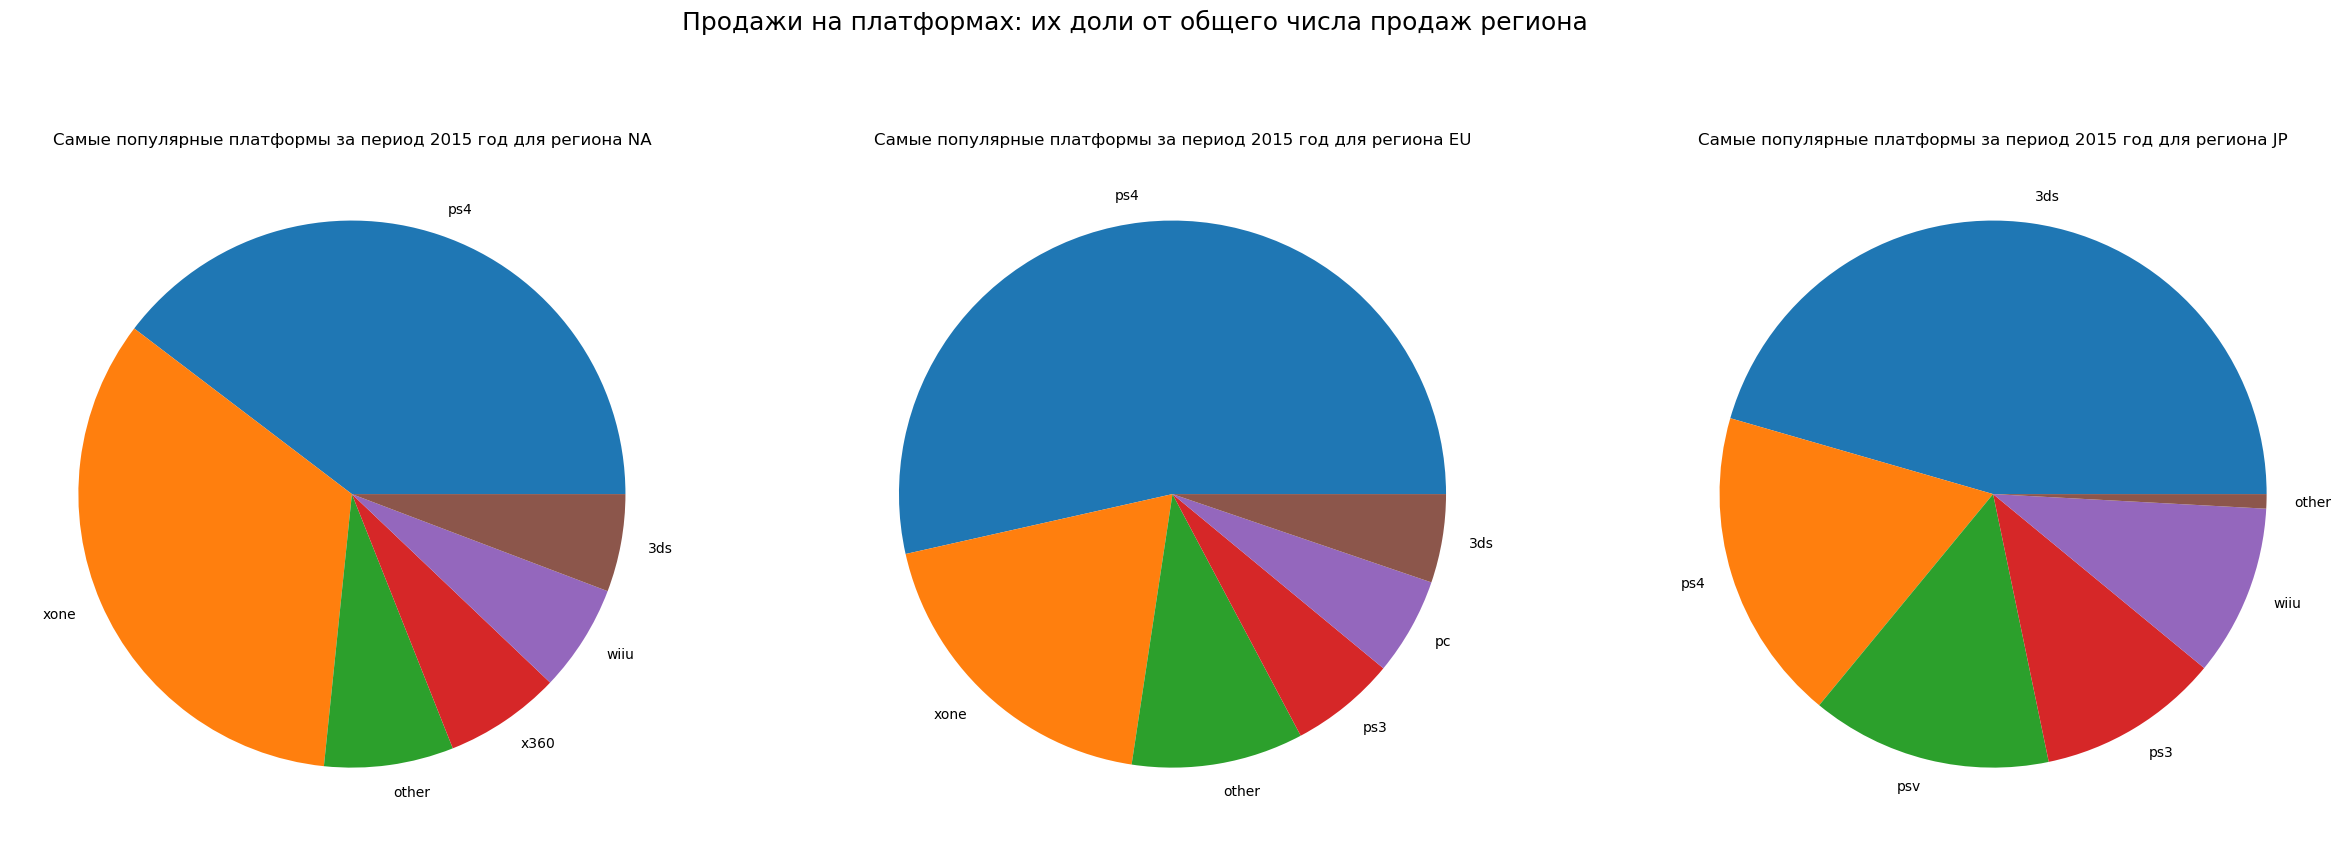

In [115]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.title(label='Самые популярные платформы за период 2015 год для региона NA')
plt.pie(x=region_na['na_sales'], labels=region_na['platform']);

plt.subplot(1, 3, 2)

plt.title(label='Самые популярные платформы за период 2015 год для региона EU')
plt.pie(x=region_eu['eu_sales'], labels=region_eu['platform']);

plt.subplot(1, 3, 3)

plt.title(label='Самые популярные платформы за период 2015 год для региона JP')
plt.pie(x=region_jp['jp_sales'], labels=region_jp['platform']);
plt.suptitle("Продажи на платформах: их доли от общего числа продаж региона",fontsize=18);

За  2015 год по продажам по трем регонам лидируют разные платформы. По представителям топ-5 во всех трех регионах фигурирует 3 платформы, что говорит, о их всеобщей популярности, их процентное соотношение представлено ниже:

- PS4 : 40%(Северная Америка) и 54%(Европа) и 19%(Япония)
- 3DS : 6%(Северная Америка) и 6%(Европа) и 46%(Япония)
- PS3 : 5%(Северная Америка) и 6%(Европа) и 11%(Япония)

Также общей популярной платформой для Северной Америки и Европы является:
- XOne : 34%(Северная Америка) и 19%(Европа)

Общей популярной платформой для Северной Америки и Японии являестя:
- WiiU : 6%(Северная Америка) и 10%(Япония)


#### Определим для пользователя каждого региона (NA, EU, JP): Самые популярные жанры (топ-5).

In [116]:
#Ограничим данные за период 2015
genre_region = (data[data['year_of_realease'].isin([2015])]
                .pivot_table(index='genre', 
                             values=(['eu_sales', 'jp_sales', 'na_sales', 'other_sales', 'sales']), 
                             aggfunc='sum')
                .reset_index()
                .sort_values(by='sales', ascending=False).head(50)
               )

In [117]:
#Процент продаж по региону от всех продаж за период 2015
genre_region['percent_na'] = genre_region['na_sales'] / genre_region['na_sales'].sum()
genre_region['percent_eu'] = genre_region['eu_sales'] / genre_region['eu_sales'].sum()
genre_region['percent_jp'] = genre_region['jp_sales'] / genre_region['jp_sales'].sum()

In [118]:
other_genre = {'genre' : 'other', 'eu_sales' : '', 'jp_sales' : '', 'na_sales' : '', 'other_sales' : '',
        'sales' : '', 'percent_na' : '', 'percent_eu' : '', 'percent_jp' : ''}

In [119]:
genre_region

,genre,eu_sales,jp_sales,na_sales,other_sales,sales,percent_na,percent_eu,percent_jp
0,Action,24.14,15.98,24.39,7.51,72.02,0.228243,0.249586,0.468759
8,Shooter,24.38,2.73,31.94,8.46,67.51,0.298896,0.252068,0.080082
10,Sports,15.81,0.73,18.77,5.53,40.84,0.175650,0.163462,0.021414
7,Role-Playing,12.93,6.80,13.93,3.98,37.64,0.130357,0.133685,0.199472
3,Misc,3.60,2.15,4.82,1.00,11.57,0.045106,0.037221,0.063068
1,Adventure,3.35,1.04,2.89,0.88,8.16,0.027045,0.034636,0.030507
6,Racing,4.75,0.28,2.09,0.95,8.07,0.019558,0.049111,0.008214
2,Fighting,2.38,0.79,3.70,1.03,7.90,0.034625,0.024607,0.023174
4,Platform,1.81,1.31,2.49,0.44,6.05,0.023302,0.018714,0.038428
9,Simulation,2.47,1.60,1.20,0.39,5.66,0.011230,0.025538,0.046935


In [120]:
#Самые популярные жанры за период 2015 для региона NA
genre_na = (genre_region
            .sort_values(by='na_sales', ascending=False)
            #.reset_index()
            )
genre_na = genre_na.append(other_genre, ignore_index=True)
genre_na.loc[12] = genre_na.loc[5] + genre_na.loc[6] +\
genre_na.loc[7] + genre_na.loc[8] + genre_na.loc[9] + genre_na.loc[10] + genre_na.loc[11]
genre_na.loc[12, 'genre'] = 'other'
genre_na = genre_na.sort_values(by='na_sales', ascending=False).head(6)

genre_na

,genre,eu_sales,jp_sales,na_sales,other_sales,sales,percent_na,percent_eu,percent_jp
0,Shooter,24.38,2.73,31.94,8.46,67.51,0.298896,0.252068,0.080082
1,Action,24.14,15.98,24.39,7.51,72.02,0.228243,0.249586,0.468759
2,Sports,15.81,0.73,18.77,5.53,40.84,0.17565,0.163462,0.021414
3,Role-Playing,12.93,6.8,13.93,3.98,37.64,0.130357,0.133685,0.199472
12,other,15.86,5.7,13.01,3.83,38.4,0.121748,0.163978,0.167204
4,Misc,3.6,2.15,4.82,1.0,11.57,0.045106,0.037221,0.063068


In [121]:
#Самые популярные жанры за период 2015 для региона EU
genre_eu = (genre_region
            .sort_values(by='eu_sales', ascending=False)
            #.reset_index()
            )
genre_eu = genre_eu.append(other_genre, ignore_index=True)
genre_eu.loc[12] = genre_eu.loc[5] + genre_eu.loc[6] +\
genre_eu.loc[7] + genre_eu.loc[8] + genre_eu.loc[9] + genre_eu.loc[10] + genre_eu.loc[11]
genre_eu.loc[12, 'genre'] = 'other'
genre_eu = genre_eu.sort_values(by='eu_sales', ascending=False).head(6)

genre_eu

,genre,eu_sales,jp_sales,na_sales,other_sales,sales,percent_na,percent_eu,percent_jp
0,Shooter,24.38,2.73,31.94,8.46,67.51,0.298896,0.252068,0.080082
1,Action,24.14,15.98,24.39,7.51,72.02,0.228243,0.249586,0.468759
2,Sports,15.81,0.73,18.77,5.53,40.84,0.17565,0.163462,0.021414
12,other,14.71,7.57,15.74,3.88,41.9,0.147296,0.152089,0.222059
3,Role-Playing,12.93,6.8,13.93,3.98,37.64,0.130357,0.133685,0.199472
4,Racing,4.75,0.28,2.09,0.95,8.07,0.019558,0.049111,0.008214


In [122]:
#Самые популярные жанры за период 2015 для региона JP
genre_jp = (genre_region
            .sort_values(by='jp_sales', ascending=False)
            #.reset_index()
            )
genre_jp = genre_jp.append(other_genre, ignore_index=True)
genre_jp.loc[12] = genre_jp.loc[5] + genre_jp.loc[6] +\
genre_jp.loc[7] + genre_jp.loc[8] + genre_jp.loc[9] + genre_jp.loc[10] + genre_jp.loc[11]
genre_jp.loc[12, 'genre'] = 'other'
genre_jp = genre_jp.sort_values(by='jp_sales', ascending=False).head(6)

genre_jp

,genre,eu_sales,jp_sales,na_sales,other_sales,sales,percent_na,percent_eu,percent_jp
0,Action,24.14,15.98,24.39,7.51,72.02,0.228243,0.249586,0.468759
1,Role-Playing,12.93,6.8,13.93,3.98,37.64,0.130357,0.133685,0.199472
12,other,29.2,4.83,30.58,8.97,73.58,0.286169,0.301902,0.141684
2,Shooter,24.38,2.73,31.94,8.46,67.51,0.298896,0.252068,0.080082
3,Misc,3.6,2.15,4.82,1.0,11.57,0.045106,0.037221,0.063068
4,Simulation,2.47,1.6,1.2,0.39,5.66,0.01123,0.025538,0.046935


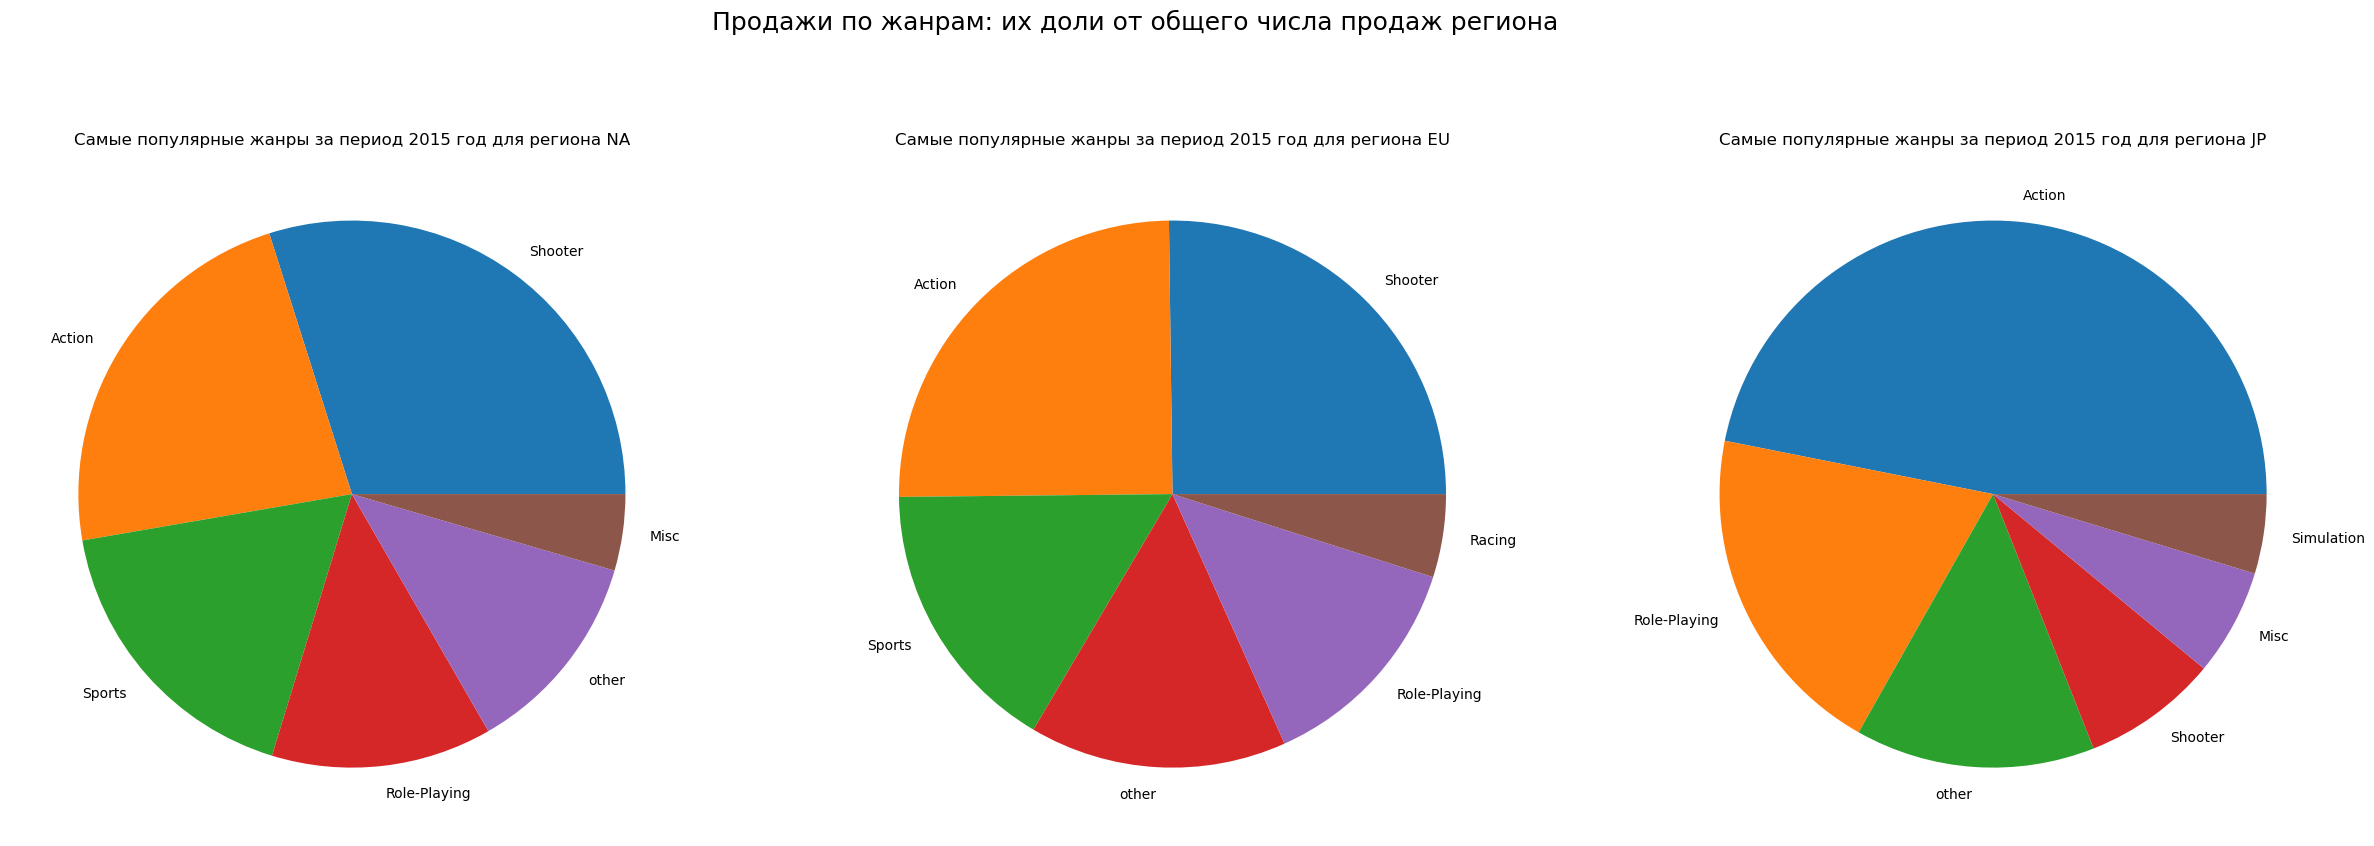

In [123]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.title(label='Самые популярные жанры за период 2015 год для региона NA')
plt.pie(x=genre_na['na_sales'], labels=genre_na['genre']);

plt.subplot(1, 3, 2)

plt.title(label='Самые популярные жанры за период 2015 год для региона EU')
plt.pie(x=genre_eu['eu_sales'], labels=genre_eu['genre']);

plt.subplot(1, 3, 3)

plt.title(label='Самые популярные жанры за период 2015 год для региона JP')
plt.pie(x=genre_jp['jp_sales'], labels=genre_jp['genre']);
plt.suptitle("Продажи по жанрам: их доли от общего числа продаж региона",fontsize=18);

По приведенным данным за 2015 год самыми популярными жанрами для всех регионов были:

- Shooter 30%(Северная Америка) и 25%(Европа) и 8%(Япония)
- Action 23%(Северная Америка) и 25%(Европа) и 47%(Япония)
- Role-Playing 13%(Северная Америка) и 13%(Европа) и 20%(Япония)

Регионы имеющие также общие жанры:

- Sports 18%(Северная Америка) и 16%(Европа)

За 2015 год для всех регионов стали популярны динамичные жанры, что может быть причиной смены интересов или аудитории, покупающей игры.

#### Определим для пользователя каждого региона (NA, EU, JP): Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [124]:
data['categorize_rating'].value_counts()

RP      6766
E       3990
T       2964
M       1564
E10+    1428
Name: categorize_rating, dtype: int64

In [125]:
#Ограничим данные 
rating = (data[data['year_of_realease'].isin([2015])]
          .pivot_table(index='categorize_rating', 
                       values=(['eu_sales', 'jp_sales', 'na_sales', 'other_sales', 'sales']),
                       aggfunc='sum')
          .reset_index()
          .sort_values(by='sales', ascending=False)
         )

In [126]:
#Процент продаж по региону от всех продаж за период 2015 г
rating['percent_na'] = rating['na_sales'] / rating['na_sales'].sum()
rating['percent_eu'] = rating['eu_sales'] / rating['eu_sales'].sum()
rating['percent_jp'] = rating['jp_sales'] / rating['jp_sales'].sum()

In [127]:
#Самые популярные по рейтингу игры за период 2015 для региона NA
rating_na = (rating
            .sort_values(by='na_sales', ascending=False)
            #.reset_index()
            )
rating_na

,categorize_rating,eu_sales,jp_sales,na_sales,other_sales,sales,percent_na,percent_eu,percent_jp
2,M,29.00,3.09,31.36,9.30,72.75,0.293468,0.299835,0.090642
3,RP,28.24,18.57,28.91,8.85,84.57,0.270541,0.291977,0.544735
0,E,21.22,4.18,18.62,5.48,49.50,0.174247,0.219396,0.122617
1,E10+,7.73,2.82,14.06,2.94,27.55,0.131574,0.079921,0.082722
4,T,10.53,5.43,13.91,3.74,33.61,0.130170,0.108871,0.159284


In [128]:
#Самые популярные по рейтингу игры за период 2015 для региона EU
rating_eu = (rating
            .sort_values(by='eu_sales', ascending=False)
            #.reset_index()
            )
rating_eu

,categorize_rating,eu_sales,jp_sales,na_sales,other_sales,sales,percent_na,percent_eu,percent_jp
2,M,29.00,3.09,31.36,9.30,72.75,0.293468,0.299835,0.090642
3,RP,28.24,18.57,28.91,8.85,84.57,0.270541,0.291977,0.544735
0,E,21.22,4.18,18.62,5.48,49.50,0.174247,0.219396,0.122617
4,T,10.53,5.43,13.91,3.74,33.61,0.130170,0.108871,0.159284
1,E10+,7.73,2.82,14.06,2.94,27.55,0.131574,0.079921,0.082722


In [129]:
#Самые популярные по рейтингу игры за период 2015 для региона JP
rating_jp = (rating
            .sort_values(by='jp_sales', ascending=False)
            #.reset_index()
            )
rating_jp

,categorize_rating,eu_sales,jp_sales,na_sales,other_sales,sales,percent_na,percent_eu,percent_jp
3,RP,28.24,18.57,28.91,8.85,84.57,0.270541,0.291977,0.544735
4,T,10.53,5.43,13.91,3.74,33.61,0.130170,0.108871,0.159284
0,E,21.22,4.18,18.62,5.48,49.50,0.174247,0.219396,0.122617
2,M,29.00,3.09,31.36,9.30,72.75,0.293468,0.299835,0.090642
1,E10+,7.73,2.82,14.06,2.94,27.55,0.131574,0.079921,0.082722


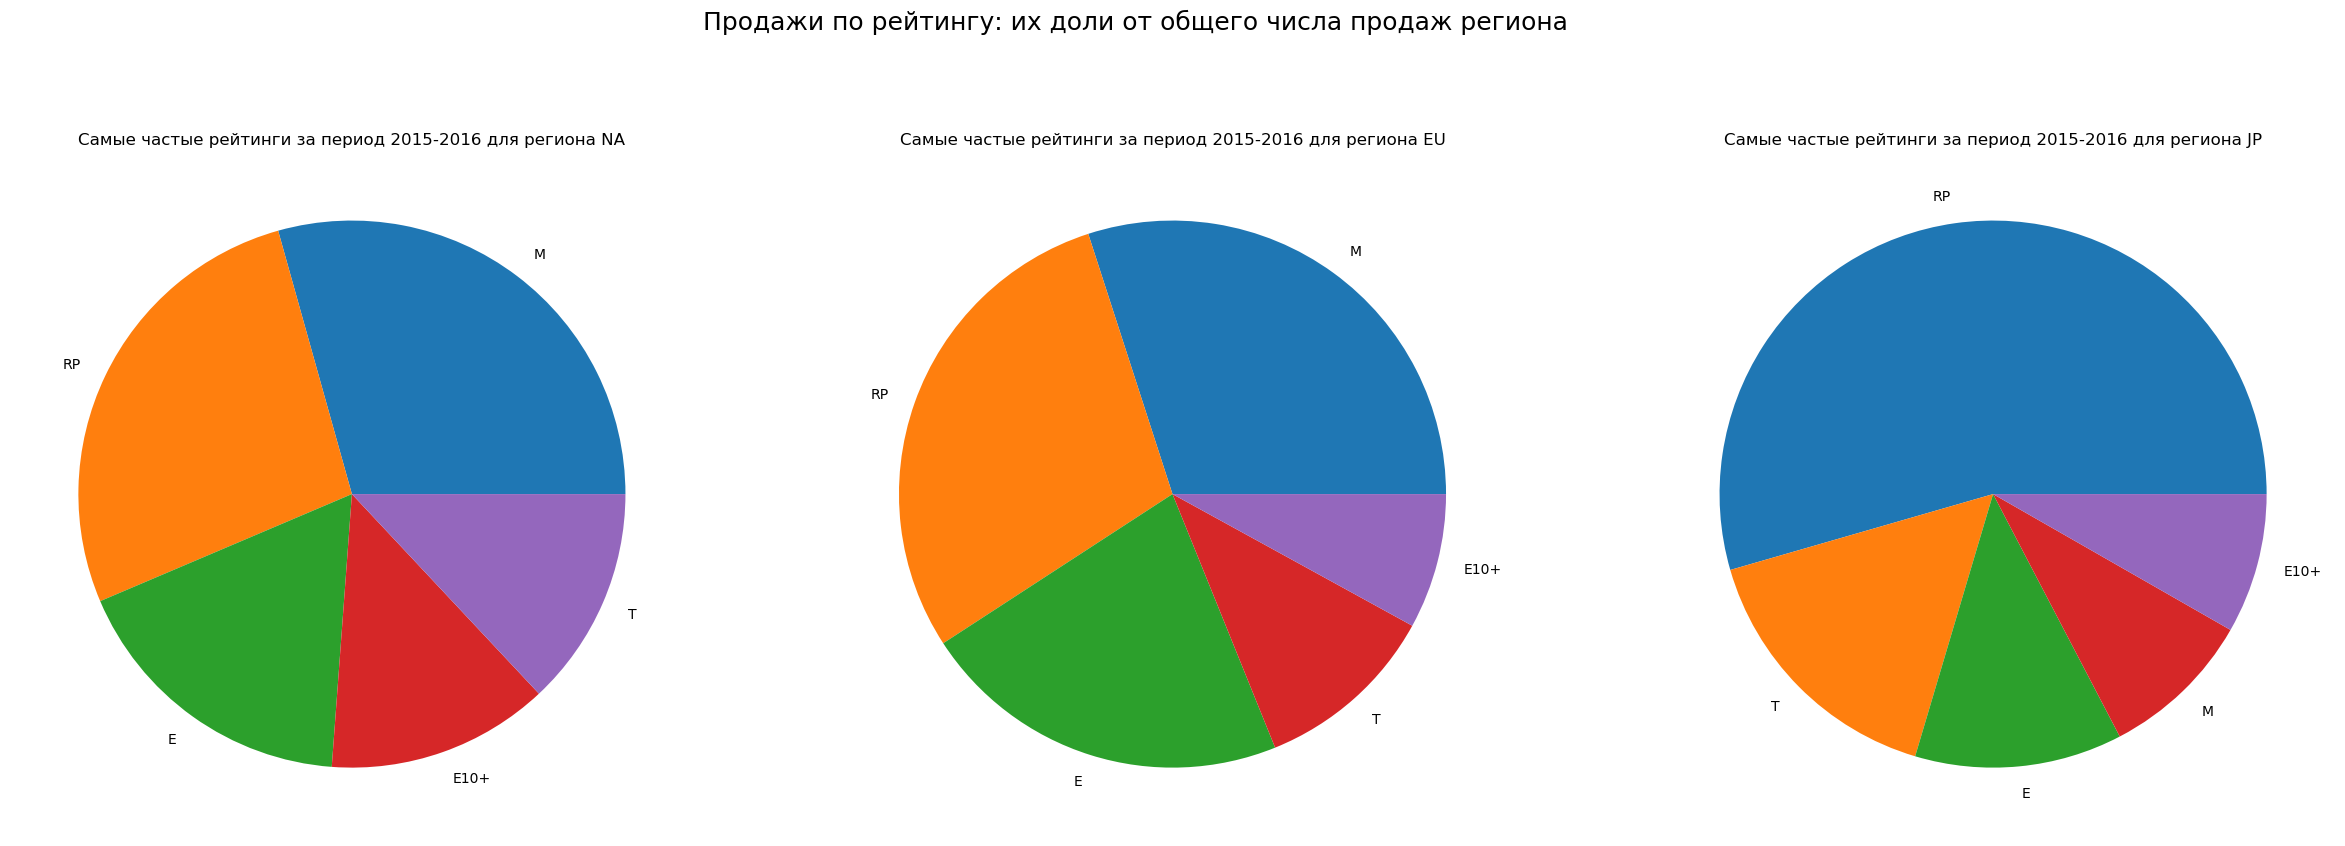

In [130]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.title(label='Самые частые рейтинги за период 2015-2016 для региона NA')
plt.pie(x=rating_na['na_sales'], labels=rating_na['categorize_rating']);

plt.subplot(1, 3, 2)

plt.title(label='Самые частые рейтинги за период 2015-2016 для региона EU')
plt.pie(x=rating_eu['eu_sales'], labels=rating_eu['categorize_rating']);

plt.subplot(1, 3, 3)

plt.title(label='Самые частые рейтинги за период 2015-2016 для региона JP')
plt.pie(x=rating_jp['jp_sales'], labels=rating_jp['categorize_rating']);
plt.suptitle("Продажи по рейтингу: их доли от общего числа продаж региона",fontsize=18);

Как можем заметить, в данных и за 2015 год по всем регионам наблюдается следующая ситуация, даже при наличии большого числа пустых значений RP, для регионов Северная Америка и Европа самыми распространенными является игры с рейтингом M - «Для взрослых», когда как в Японии данный жанр занимает лишь 4 место.

Если не брать в расчет рейтинг RP следующим для Северной Америки и Европы идет E - «Для всех» - доли 17% и	22% соответственно.

По данным рейтинга, можно утверждать, что пользователями в  Северной Америке и Европе в большей степени являются взрослые, когда как в Японии рынок более заточен на подрастающую аудиторию.

### Шаг 5. Проверим гипотезы

#### Гипотеза 1
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
Задайте самостоятельно пороговое значение alpha.
Поясните:
Как вы сформулировали нулевую и альтернативную гипотезы;
Какой критерий применили для проверки гипотез и почему.

In [131]:
rating_XOne = data[(data['platform'] == 'xone')&(~(data['user_score'].isna()))]
#display(rating_XOne)

In [132]:
rating_PC = data[(data['platform'] == 'pc')&(~(data['user_score'].isna())&(data['year_of_realease']>2012))]
#display(rating_PC)

- H0 - средние пользовательские рейтинги платформ Xbox One и PC одинаковые 
- H1 - средние пользовательские рейтинги платформ Xbox One и PC не равны

Для проверки применим t-тест, так как на вход подаются две независимые выборки.

In [133]:
#Задаем уровень стат. значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем двухстороннюю гипотезу 
results = st.ttest_ind(rating_XOne['user_score'], rating_PC['user_score'])

print(f'p-value: {round(results.pvalue,2)}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.16
Нет оснований отвергнуть нулевую гипотезу


С вероятнотью почти в 16% можно случайным образом получить отклонение в пользовательском рейтинге между двумя платформами, учитывая, что пользовательский рейтинг может быть неоднородным и зависить от разных факторов. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними пользовательскими рейтингами платформ Xbox One и PC.

In [134]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:

    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


#### Гипотеза 2
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
Задайте самостоятельно пороговое значение alpha.
Поясните:
Как вы сформулировали нулевую и альтернативную гипотезы;
Какой критерий применили для проверки гипотез и почему.

In [135]:
rating_action = data[(data['genre'] == 'Action')&(~(data['user_score'].isna()))]
#display(rating_action)

In [136]:
rating_sports = data[(data['genre'] == 'Sports')&(~(data['user_score'].isna()))]
#display(rating_sports)

- H0 - средние пользовательские рейтинги жанров Action и Sports одинаковые 
- H1 - средние пользовательские рейтинги жанров Action и Sports не равны

Для проверки применим t-тест, так как на вход подаются две независимые выборки.

In [137]:
#Задаем уровень стат. значимости
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем двухстороннюю гипотезу 
results = st.ttest_ind(rating_action['user_score'], rating_sports['user_score'])

print(f'p-value: {round(results.pvalue,2)}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.1
Нет оснований отвергнуть нулевую гипотезу


С вероятностью примерно 10% случайным образом средние пользовательские рейтинги жанров Action и Sports будут не равны, это большая вероятность, чтобы сделать вывод о значимом различии между средними пользовательскими рейтингами жанров.

### Общий вывод

В результате проведенного анализа, были выполнеы следующие этапы:

предобработка данных (были удалены и заполнены пустые значения, обработаны аномалии)
на основе обработанных данных были добавлены необходимые для дальнейшего анализа графы
был проведен анализ как данных по отдельности, так и в совокупности

По результатам анализа можно утверждать следующее:

1) При анализе для прогноза на определенный год (например на 2017), данные за весь период не обязательны, ведь большинство платформ и игр популярных в 90-х и 2000-х не актуальны в настоящее время, то есть платформы и игры исчезли с рынка. Данные полезны для рассмотрения динамики развития индустрии в целом.
Для прогноза на 2017 год нужно более подробно рассмотреть игры и платформы распространенные в 2014-2015 годах, так как данные по 2016 году не являются полными, а также динамику развится ситуации на рынке, примерный диапазон 1-2 года, для данной динамично развивающейся области.


2) За анализируемый период 2015г, только у двух платформ наблюдается восходящая тенденция: PS4 и XOne, также данные платформы являются самыми прибыльными.

На основе вышеизложенного наиболее перспективными платформами на 2017 год по имеющимся данным являются PS4 и XOne, данные платформы рекомендуемы маркетологам компании.

Так же к рекомендуемым платформам можно отнести те, чьи продажи были достаточны высоки и угол наклонной на графике не очень большой или же продажи обусловлены многолетним удачным опытом продаж.
К таким платформам можно отнести 3DS, которая заняла 3-е место по количеству проданных копий в 2015 году (~27 млн.копий). Также платформа PC может быть представлена отделу маркетнга, так как зарекомендовала себя как устойчивая платформа по продажам в данной индустрии.

Платформы PS3 и WiiU за 2015 год имеют ~18 млн. проданных копий, что также может быть предложено отделу маркетинга на рассмотрение.

3) Отзывы  критиков и пользователей могут влиять на продажи игр, но также полученные в результатае анализа данные могут быть недостоверными из-за недостаточности предсталенных значений и являться ложными.

4) Самыми устойчивыми на рынке являются жанры медианная которых при разных условиях разброса аномальных величин будет принадлежать промежутку от 0,25-квантиля до 0,75-квантиля.

За анлизируемый период самыми стабильными являются жанры Adventure (0.030) и Puzzle (0.030). Данные жанры в меньшей степени чем остальные зависят от временной популярности, актуальности. 

Остальные жанры в большей степени подвержены временным колебаниям разных факторов. Данный факт выражается в большом значении стандартного отклонения от средней, чем дальше медианное значение жанра от расчетного, тем нестабильнее и сложнее прогнозируемыми будут становиться продажи.

Жанр с самыми большими продажами - Shooter, даже при условии небольшого количества игр за 2015г на грфике представлен самый большой межквартильный размах, что говорит о разбросе данных. Соотношение относительно небольшого количества игр к продажам может быть причиной широкой популярности данного жанра. 

5) За  2015 год по продажам по трем регонам лидируют разные платформы. По представителям топ-5 во всех трех регионах фигурирует 3 платформы, что говорит, о их всеобщей популярности, их процентное соотношение представлено ниже:

- PS4 : 40%(Северная Америка) и 54%(Европа) и 19%(Япония)
- 3DS : 6%(Северная Америка) и 6%(Европа) и 46%(Япония)
- PS3 : 5%(Северная Америка) и 6%(Европа) и 11%(Япония)

Также общей популярной платформой для Северной Америки и Европы является:
- XOne : 34%(Северная Америка) и 19%(Европа)

Общей популярной платформой для Северной Америки и Японии являестя:
- WiiU : 6%(Северная Америка) и 10%(Япония)

6) По приведенным данным за 2015 год самыми популярными жанрами для всех регионов были:

- Shooter 30%(Северная Америка) и 25%(Европа) и 8%(Япония)
- Action 23%(Северная Америка) и 25%(Европа) и 47%(Япония)
- Role-Playing 13%(Северная Америка) и 13%(Европа) и 20%(Япония)

Регионы имеющие также общие жанры:

- Sports 18%(Северная Америка) и 16%(Европа)

За 2015 год для всех регионов стали популярны динамичные жанры, что может быть причиной смены интересов или аудитории, покупающей игры.


7) Как можем заметить, в данных и за 2015 год по всем регионам наблюдается следующая ситуация, даже при наличии большого числа пустых значений RP, для регионов Северная Америка и Европа самыми распространенными является игры с рейтингом M - «Для взрослых», когда как в Японии данный жанр занимает лишь 4 место.

Если не брать в расчет рейтинг RP следующим для Северной Америки и Европы идет E - «Для всех» - доли 17% и	22% соответственно.

По данным рейтинга, можно утверждать, что пользователями в  Северной Америке и Европе в большей степени являются взрослые, когда как в Японии рынок более заточен на подрастающую аудиторию.

Из полученых результатов можно заключить, что на популярность платформ и компьютерных игр влияют различные факторы в совокупности, начиная от количественных характеристик до оценочных данных. Для выявления более точных возможных факторов популярности той или иной платформы или жанра необходимо проводить точечный анализ требуемых величин.